 # 🗼⚡**Energy Consumption Modeling, Forecasting and Causal Inference For Business Understanding**

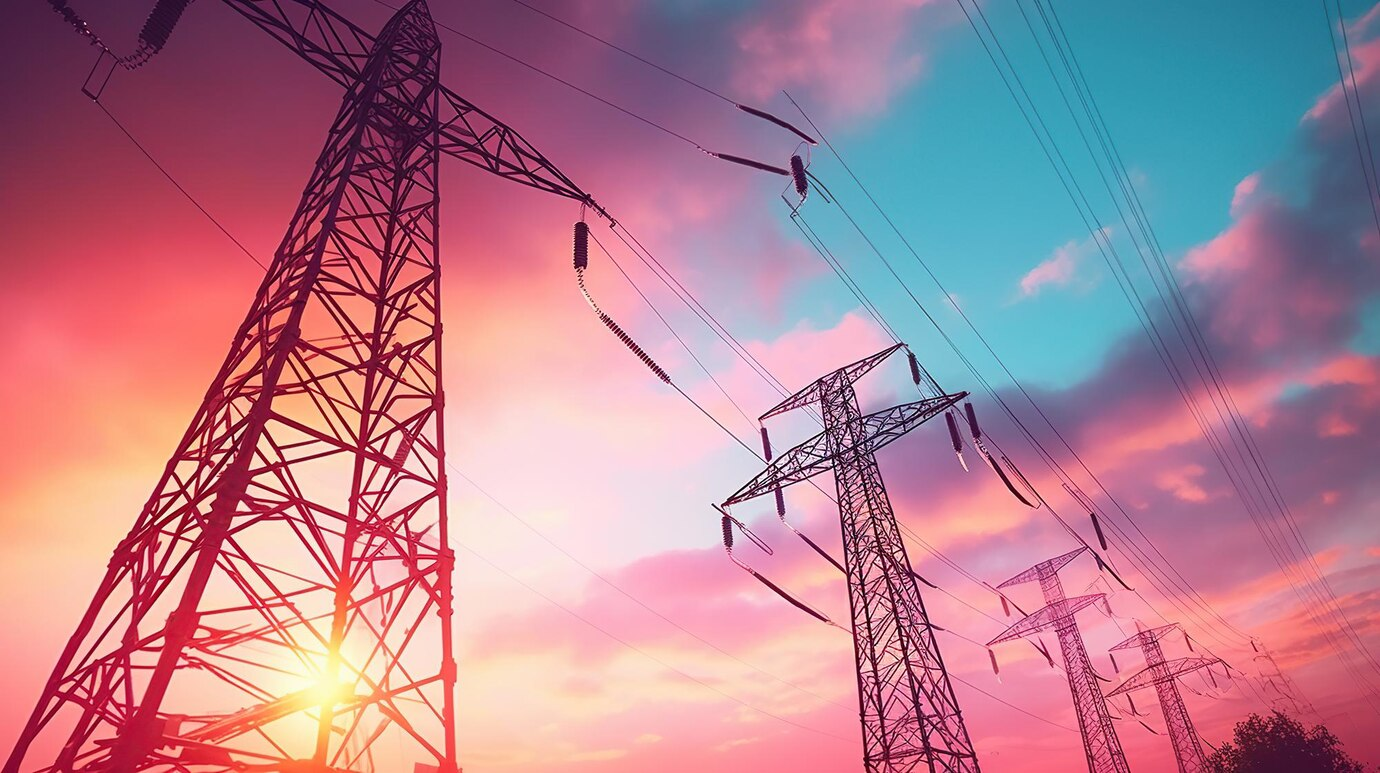

# Dataset
> PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

There are a total of 12 main datasets with features **date** and **energy consumption** in MegaWatts

The 12 main datasets include:
1. AEP
2. COMED
3. DAYTON
4. DEOK
5. DOM
6. DUQ
7. EKPC
8. FE
9. NI
10. PJM
11. PJME
12. PJMW

**Dataset Link**: [Hourly Energy Consumption Dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
)

# Project Management Decision

>  In order to build this I will follow the CRISP-DM approach of project management.

>  The reasons for doing so are as follows:

- This project has a clear objective, where I will build forecast models to understand demand and derive causal inferences to develop business understanding.
- The project is an end-to-end pipline with documentation so that it allows easy traceability and reproduciability in future.
- There is minimal stakeholder involvement as it is an individual project

> The diagram below shows the important blocks required to manage and build a project that follows CRISP-DM strategy:

crisp-dm_diagram2.svg

## 🚨 1. Business Understanding
> ✅ From  a business perspective we want to ask the question:
  - Q1. Can we forecast energy demands upto a certain number of time steps into the future?

> ✅ Importance of exploring this business question:
  - Planning and regulations to meet future demands
  - Scaling and equipment demands
  - Risk analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from google.colab import files


from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import date
from tabulate              import tabulate
from scipy.stats           import chi2_contingency

from sklearn.ensemble      import RandomForestRegressor

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from dowhy import CausalModel


import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor


import random
import warnings
warnings.filterwarnings( 'ignore' )

## Upload data from device

In [3]:
# file upload from local drive
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv
Saving COMED_hourly.csv to COMED_hourly.csv
Saving DAYTON_hourly.csv to DAYTON_hourly.csv
Saving DEOK_hourly.csv to DEOK_hourly.csv
Saving df_ComED_sorted.csv to df_ComED_sorted.csv
Saving df_feature_eng.csv to df_feature_eng.csv
Saving DOM_hourly.csv to DOM_hourly.csv
Saving DUQ_hourly.csv to DUQ_hourly.csv
Saving EKPC_hourly.csv to EKPC_hourly.csv
Saving FE_hourly.csv to FE_hourly.csv
Saving NI_hourly.csv to NI_hourly.csv
Saving pjm_hourly_est.csv to pjm_hourly_est.csv
Saving PJM_Load_hourly.csv to PJM_Load_hourly.csv
Saving PJME_hourly.csv to PJME_hourly.csv
Saving PJMW_hourly.csv to PJMW_hourly.csv


# Data Loading

In [ ]:
aep = pd.read_csv( '/content/AEP_hourly.csv', low_memory=False )
comed = pd.read_csv( '/content/COMED_hourly.csv', low_memory=False )
dayton = pd.read_csv( '/content/DAYTON_hourly.csv', low_memory=False )
deok = pd.read_csv( '/content/DEOK_hourly.csv', low_memory=False )
dom = pd.read_csv( '/content/DOM_hourly.csv', low_memory=False )
duq = pd.read_csv( '/content/DUQ_hourly.csv', low_memory=False )
ekpc = pd.read_csv( '/content/EKPC_hourly.csv', low_memory=False )
fe = pd.read_csv( '/content/FE_hourly.csv', low_memory=False )
ni = pd.read_csv( '/content/NI_hourly.csv', low_memory=False )
pjm = pd.read_csv( '/content/PJM_Load_hourly.csv', low_memory=False )
pjme = pd.read_csv( '/content/PJME_hourly.csv', low_memory=False )
pjmw = pd.read_csv( '/content/PJMW_hourly.csv', low_memory=False )

## Concatenate the data into one consolidated dataset with information on all companies and their respective energy consumptions:



> ▶ Create an extra column with company names




In [ ]:
aep['electric_company'] = 'AEP'
comed['electric_company'] = 'COMED'
dayton['electric_company'] = 'DAYTON'
deok['electric_company'] = 'DEOK'
dom['electric_company'] = 'DOM'
duq['electric_company'] = 'DUQ'
ekpc['electric_company'] = 'EKPC'
fe['electric_company'] = 'FE'
ni['electric_company'] = 'NI'
pjm['electric_company'] = 'PJM'
pjme['electric_company'] = 'PJME'
pjmw['electric_company'] = 'PJMW'

> ▶ The energy consumption column name should be same in all the dataframes, therefore it has to be renamed

In [ ]:
aep = aep.rename( columns={'AEP_MW': 'mw_energy'} )
comed = comed.rename( columns={'COMED_MW': 'mw_energy'} )
dayton = dayton.rename( columns={'DAYTON_MW': 'mw_energy'} )
deok = deok.rename( columns={'DEOK_MW': 'mw_energy'} )
dom = dom.rename( columns={'DOM_MW': 'mw_energy'} )
duq = duq.rename( columns={'DUQ_MW': 'mw_energy'} )
ekpc = ekpc.rename( columns={'EKPC_MW': 'mw_energy'} )
fe = fe.rename( columns={'FE_MW': 'mw_energy'} )
ni = ni.rename( columns={'NI_MW': 'mw_energy'} )
pjm = pjm.rename( columns={'PJM_Load_MW': 'mw_energy'} )
pjme = pjme.rename( columns={'PJME_MW': 'mw_energy'} )
pjmw = pjmw.rename( columns={'PJMW_MW': 'mw_energy'} )

In [ ]:
# Concatenating
df_main = pd.concat( [aep, comed, dayton, deok, dom, duq, ekpc, fe, ni, pjm, pjme, pjmw] )
df_main.sample(8)

,Datetime,mw_energy,electric_company
53359,2011-11-29 21:00:00,1813.0,DUQ
79000,2011-12-26 12:00:00,29885.0,PJME
105509,2017-12-17 01:00:00,1441.0,DUQ
64193,2012-12-04 10:00:00,1935.0,DAYTON
65439,2012-10-13 09:00:00,1745.0,DAYTON
14315,2003-05-14 15:00:00,30798.0,PJME
6777,2012-03-24 11:00:00,2561.0,DEOK
25733,2007-04-25 12:00:00,16073.0,AEP


# 📊 2. Data Understanding

> ▶ Data shape and primary information on the data

In [ ]:
print(df_main.shape)
df_main.info()

(1090167, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 1090167 entries, 0 to 143205
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Datetime          1090167 non-null  object 
 1   mw_energy         1090167 non-null  float64
 2   electric_company  1090167 non-null  object 
dtypes: float64(1), object(2)
memory usage: 33.3+ MB


In [ ]:
# Creating a copy of the main dataframe
df_anlaysis = df_main.copy()

In [ ]:
# Column renaming
df_anlaysis.rename(columns={'Datetime':'datetime'}, inplace=True)
print(df_anlaysis.columns)

Index(['datetime', 'mw_energy', 'electric_company'], dtype='object')


In [ ]:
# Understanding datatypes
df_anlaysis.dtypes

,0
datetime,object
mw_energy,float64
electric_company,object


> ▶ Convert *'datetime'* column from **string object** dtype to **datetime object** dtype   

In [ ]:
df_anlaysis['datetime'] = pd.to_datetime(df_anlaysis['datetime'])

In [ ]:
# Ensuring datatype transform
df_anlaysis.dtypes

,0
datetime,datetime64[ns]
mw_energy,float64
electric_company,object


 ## 📉 3. Data Preparation

### 🔎 Checking Missing and Null Values

In [ ]:
df_anlaysis.isna().sum()

,0
datetime,0
mw_energy,0
electric_company,0


In [ ]:
df_anlaysis.isnull().sum()

,0
datetime,0
mw_energy,0
electric_company,0


> 💡 No imputation required for the consolidated dataset as it doesnot have any missing values

### 🔬📊  Descriptive Statistics

> ▶ Splitting dataframe into numerical and categorical attributes

In [ ]:
num_features = df_anlaysis.select_dtypes(include=['float64'])
cat_features = df_anlaysis.select_dtypes(exclude=['float64', 'datetime64[ns]'])

In [ ]:
# sample of numerical features
num_features.sample()


,mw_energy
65101,12267.0


In [ ]:
# sample of categorical features
cat_features.sample()

,electric_company
103856,AEP


###📈 Numerical Statitics: Central tendencies, dispersion, skewness and kurtosis

In [ ]:
# Central Tendencies
## Mean
num_mean = pd.DataFrame(num_features.apply(np.mean)).T
## Median
num_median = pd.DataFrame(num_features.apply(np.median)).T

# Dispersion
num_std = pd.DataFrame( num_features.apply( np.std ) ).T
num_min = pd.DataFrame( num_features.apply( min ) ).T
num_max = pd.DataFrame( num_features.apply( max ) ).T
num_range = pd.DataFrame( num_features.apply( lambda x: x.max() - x.min() ) ).T
num_skew = pd.DataFrame( num_features.apply( lambda x: x.skew() ) ).T
num_kurtosis = pd.DataFrame( num_features.apply( lambda x: x.kurtosis() ) ).T

# concatenate stats
num_concat = pd.concat([num_min, num_max, num_range, num_median, num_mean, num_std, num_skew, num_kurtosis]).T.reset_index()
num_concat.columns = (['Feature', 'min', 'max', 'range', 'median', 'mean', 'std', 'skew', 'kurtosis'])

In [ ]:
num_concat

,Feature,min,max,range,median,mean,std,skew,kurtosis
0,mw_energy,0.0,62009.0,62009.0,8217.0,11209.58865,10534.394704,1.356423,1.198281


> ▶ FUNCTION: Jupyter Notebook Settings

In [ ]:
# jupyter settings function
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'fivethirtyeight' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


<Axes: xlabel='mw_energy', ylabel='Density'>

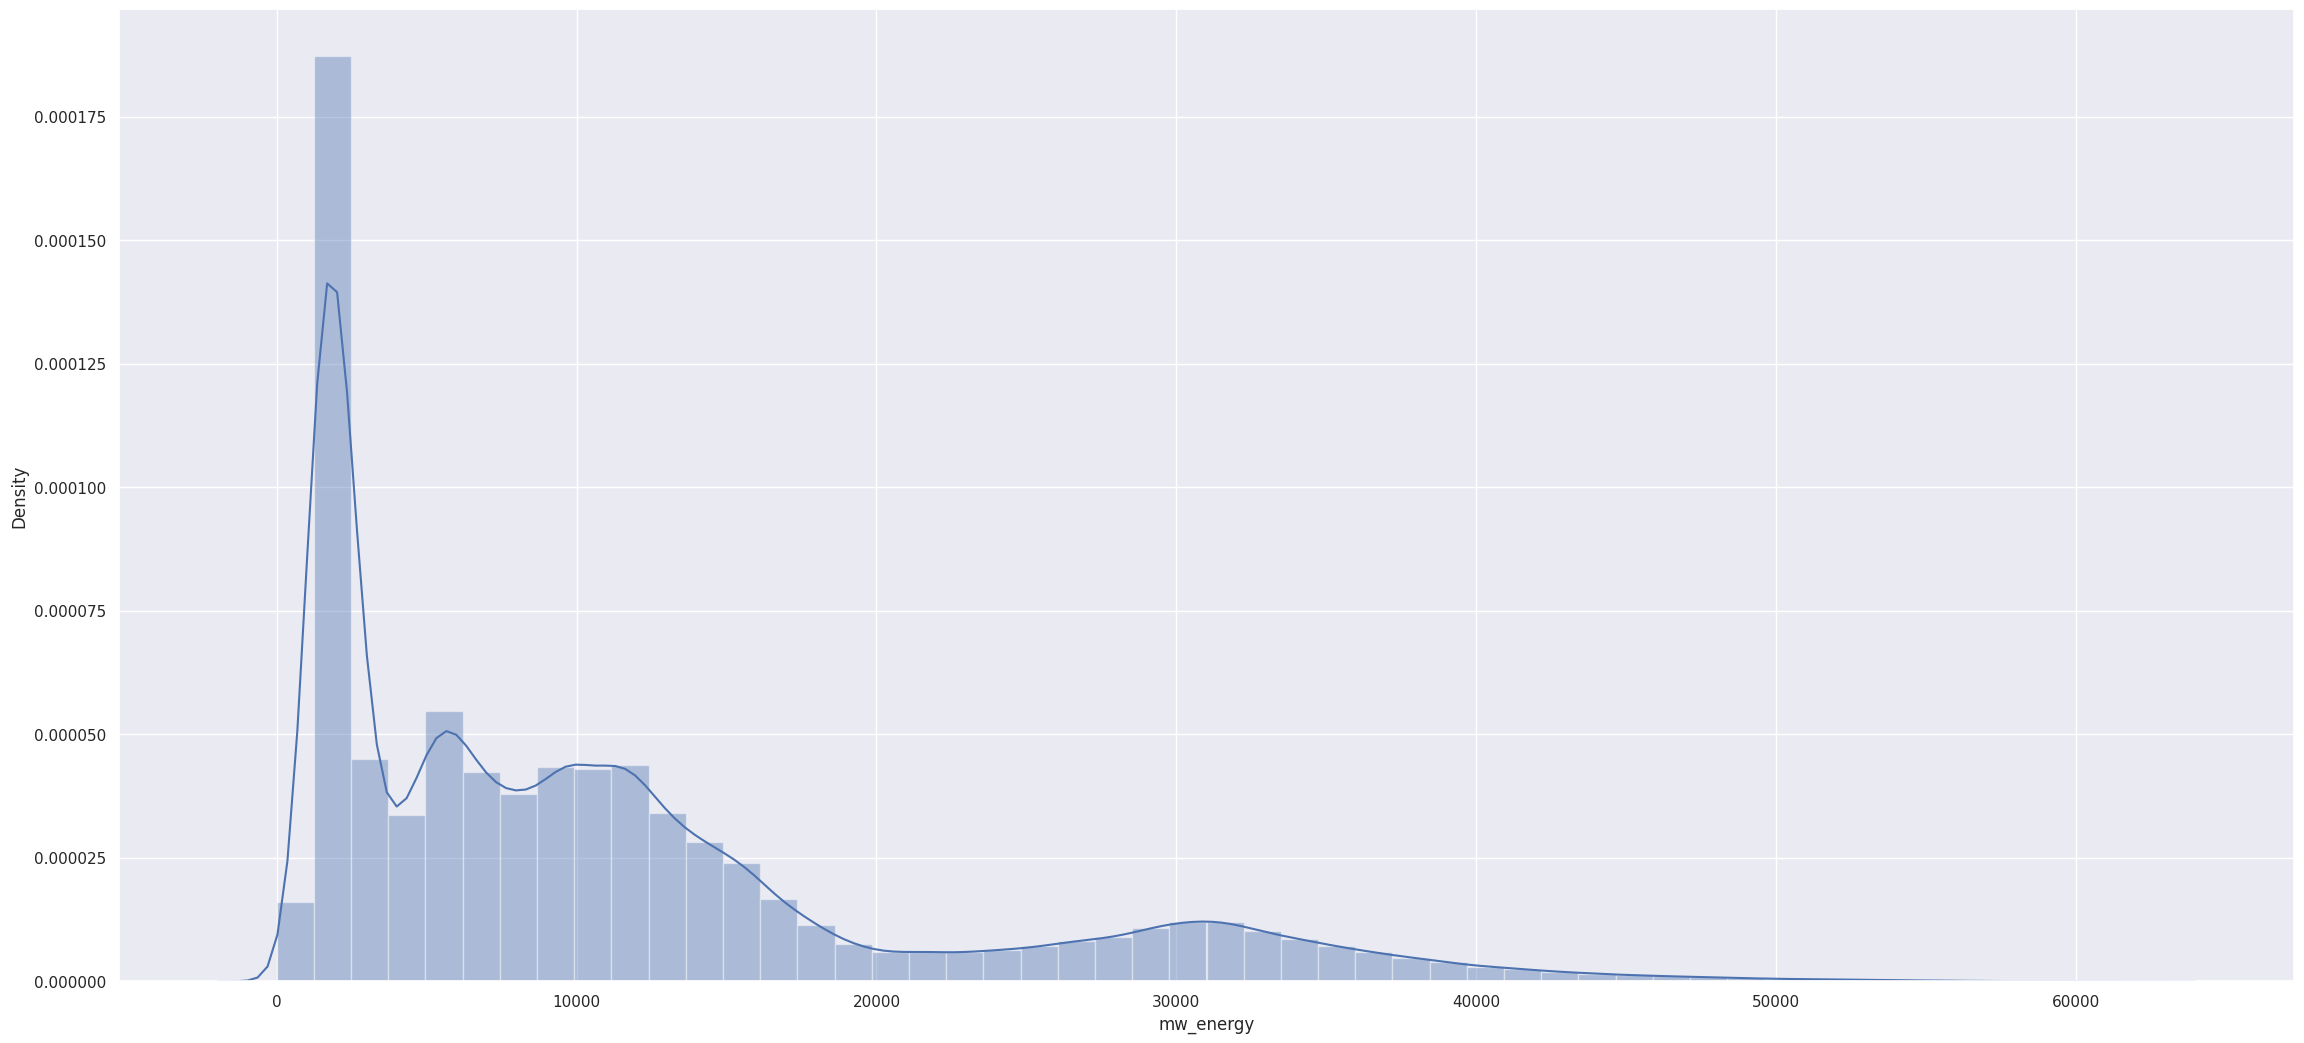

In [ ]:
# Distribution plot of energy consumption
sns.distplot(df_anlaysis['mw_energy'])

### 🆎 Categorical Statistics observing energy consumption per company

In [ ]:
cat_features.apply( lambda x: x.unique().shape[0] )

,0
electric_company,12


<Axes: xlabel='electric_company', ylabel='mw_energy'>

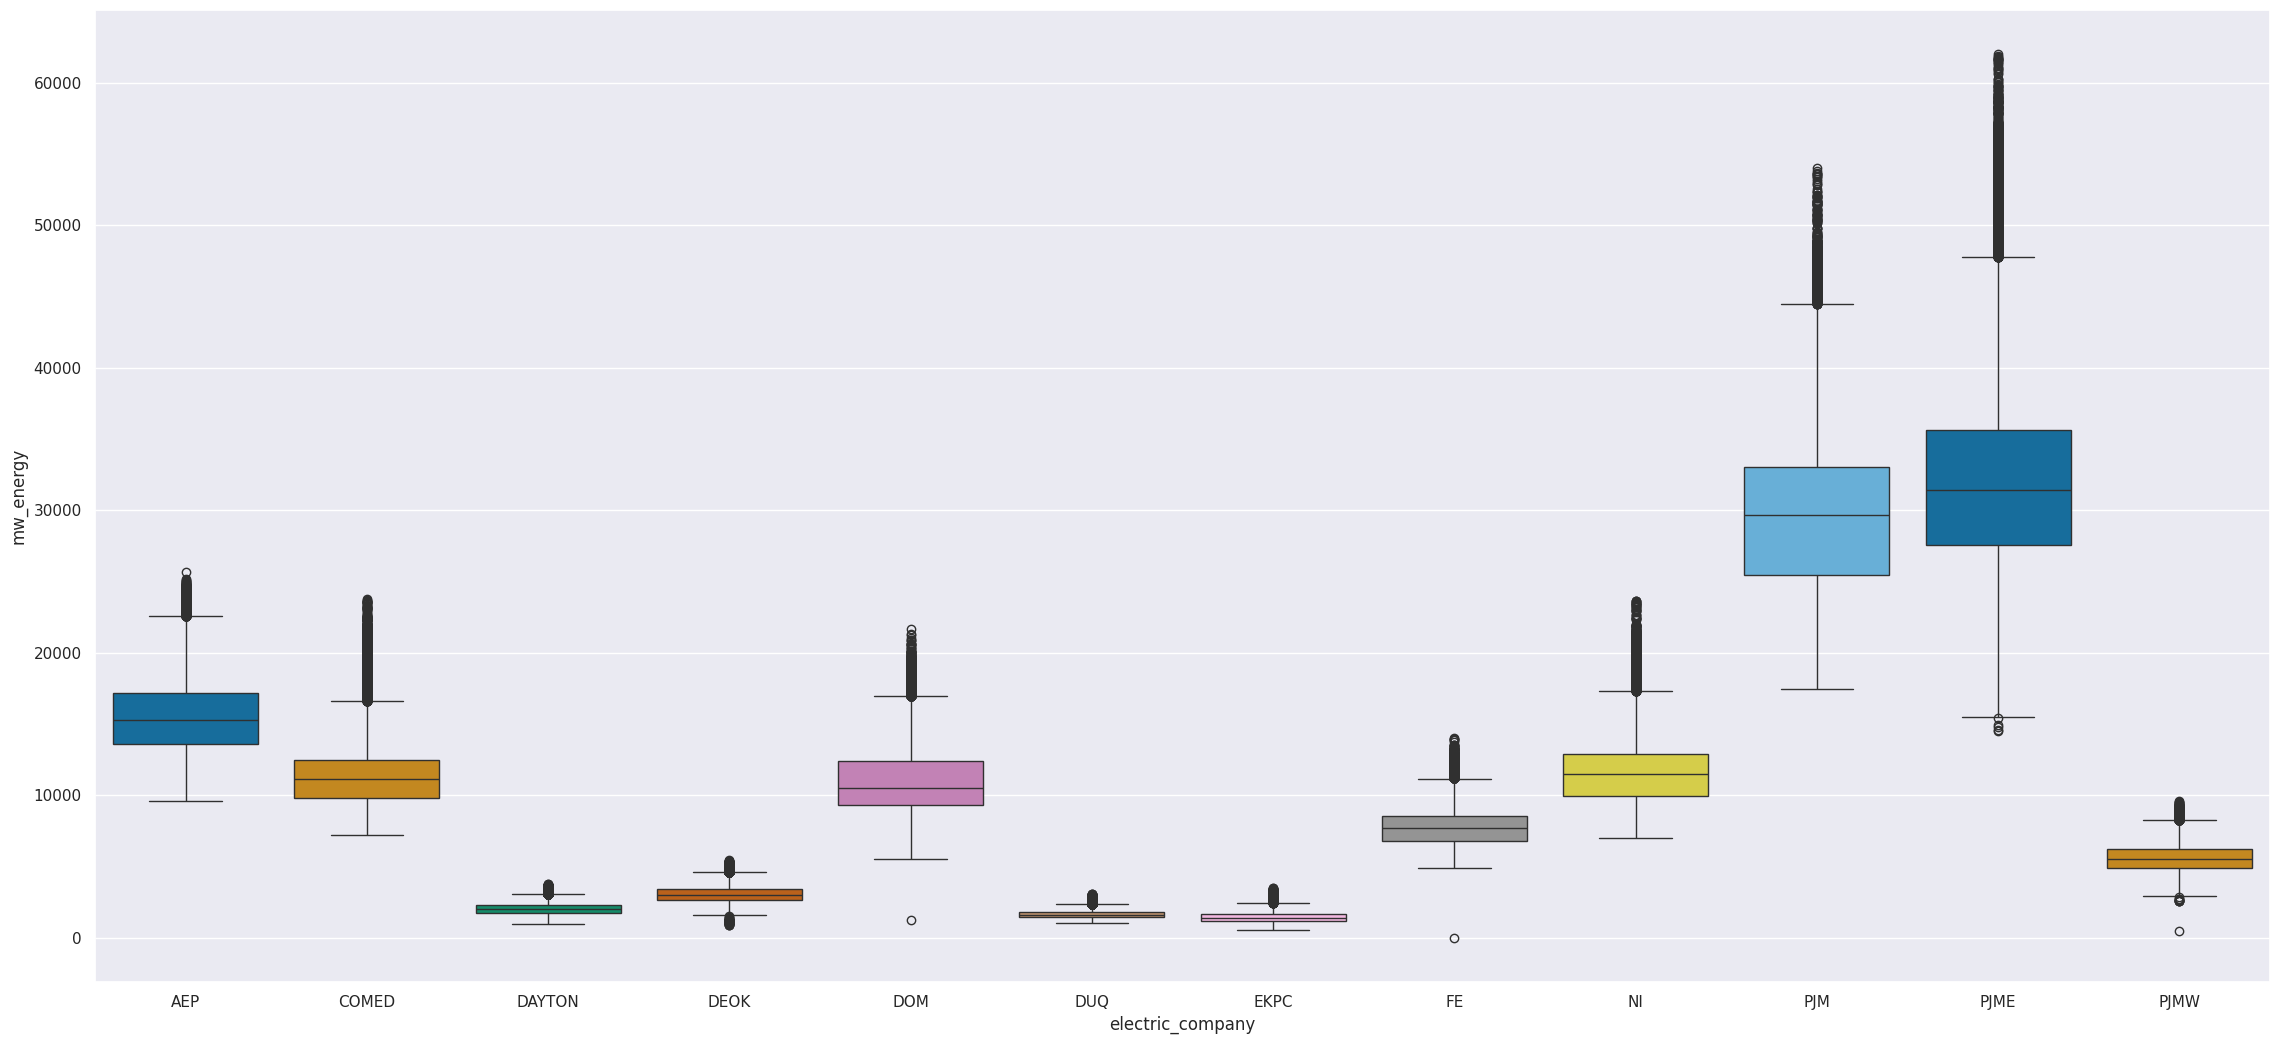

In [ ]:
# box plot of energy consumption recorded by each company
# Sample palette with different colors for each company

sns.boxplot( x= 'electric_company', y='mw_energy' , data=df_anlaysis, palette="colorblind" )

### 👷 Feature Engineering
>  - Researching energy consumption literature revealed the various factors that can affect energy consumption over time
>  - We will try to probe into some of these aspects to reason business decision making
>  - Below I narrow down some critical factors in the form of a mindmap


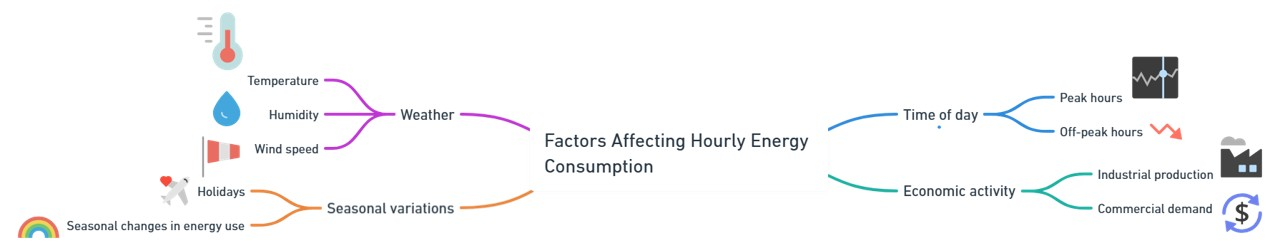

In [ ]:
# copying the processed dataframe
df_feature_eng = df_anlaysis.copy()

> ### Keeping the factors narrowed down the following features will be extarcted:

> * Date
* Year
* Month
* Hour of the Day
* Seasons
* Holidays


In [ ]:
# Date
df_feature_eng['date'] = df_feature_eng['datetime'].dt.date

# Year
df_feature_eng['year'] = df_feature_eng['datetime'].dt.year

# Month
df_feature_eng['month'] = df_feature_eng['datetime'].dt.month

# Hour
df_feature_eng['hour'] = df_feature_eng['datetime'].dt.hour

# Seasons Time Segments
# Winter -> December (12), January (01) and February (02);
# Spring -> March (03), April (04) and May (05);
# Summer -> Jun (06), July (07) and August (08);
# Autumn -> September (09), October (10) and November (11).
df_feature_eng['season'] = df_feature_eng['datetime'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

# US Federal Holidays
df_feature_eng['holidays'] = df_feature_eng['datetime'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )


# Day of week:

# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday
df_feature_eng['day_of_week'] = df_feature_eng['datetime'].dt.weekday

In [ ]:
# datatype check post feature engineering
df_feature_eng.dtypes

,0
datetime,datetime64[ns]
mw_energy,float64
electric_company,object
date,object
year,int32
month,int32
hour,int32
season,object
holidays,object
day_of_week,int32


In [ ]:
# Saving the dataframe
df_feature_eng.to_csv('df_feature_eng.csv', index=False)


In [ ]:
# Download to device from Google Colab
files.download('df_feature_eng.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Changing 'date' column to datetime object
df_feature_eng['date'] = pd.to_datetime(df_feature_eng['date'])

In [ ]:
df_feature_eng.dtypes

,0
datetime,datetime64[ns]
mw_energy,float64
electric_company,object
date,datetime64[ns]
year,int32
month,int32
hour,int32
season,object
holidays,object
day_of_week,int32


In [ ]:
df_feature_eng.head()

,datetime,mw_energy,electric_company,date,year,month,hour,season,holidays,day_of_week
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,Holiday,4
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,Holiday,4
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,Holiday,4
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,Holiday,4
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,Holiday,4


In [ ]:
df_feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090167 entries, 0 to 143205
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1090167 non-null  datetime64[ns]
 1   mw_energy         1090167 non-null  float64       
 2   electric_company  1090167 non-null  object        
 3   date              1090167 non-null  datetime64[ns]
 4   year              1090167 non-null  int32         
 5   month             1090167 non-null  int32         
 6   hour              1090167 non-null  int32         
 7   season            1090167 non-null  object        
 8   holidays          1090167 non-null  object        
 9   day_of_week       1090167 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(4), object(3)
memory usage: 74.9+ MB


In [ ]:
num_features2 = df_feature_eng.select_dtypes( include=['int64', 'int32','float64'] )
cat_features2 = df_feature_eng.select_dtypes( exclude=['int64','int32', 'float64', 'datetime64[ns]'] )

In [ ]:
num_features2.dtypes

,0
mw_energy,float64
year,int32
month,int32
hour,int32
day_of_week,int32


In [ ]:
cat_features2.dtypes

,0
electric_company,object
season,object
holidays,object


In [ ]:
df_feature_eng.sample(10).T

,10894,15549,28891,8845,31775,111843,18667,132742,45937,25898
datetime,1999-07-05 02:00:00,2006-06-23 02:00:00,2008-12-14 03:00:00,2012-12-28 16:00:00,2014-05-17 05:00:00,2015-12-28 05:00:00,2004-08-15 01:00:00,2017-08-11 23:00:00,2017-10-05 05:00:00,2016-08-18 03:00:00
mw_energy,33612.0,14142.0,1709.0,12223.0,8416.0,4351.0,4428.0,5626.0,2334.0,1158.0
electric_company,PJM,AEP,DAYTON,COMED,COMED,PJMW,PJMW,PJMW,DEOK,EKPC
date,1999-07-05 00:00:00,2006-06-23 00:00:00,2008-12-14 00:00:00,2012-12-28 00:00:00,2014-05-17 00:00:00,2015-12-28 00:00:00,2004-08-15 00:00:00,2017-08-11 00:00:00,2017-10-05 00:00:00,2016-08-18 00:00:00
year,1999,2006,2008,2012,2014,2015,2004,2017,2017,2016
month,7,6,12,12,5,12,8,8,10,8
hour,2,2,3,16,5,5,1,23,5,3
season,Summer,Summer,Winter,Winter,Spring,Winter,Summer,Summer,Autumn,Summer
holidays,Holiday,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day,Normal day
day_of_week,0,4,6,4,5,0,6,4,3,3


In [ ]:
df_feature_eng.head()

,datetime,mw_energy,electric_company,date,year,month,hour,season,holidays,day_of_week
0,2004-12-31 01:00:00,13478.0,AEP,2004-12-31,2004,12,1,Winter,Holiday,4
1,2004-12-31 02:00:00,12865.0,AEP,2004-12-31,2004,12,2,Winter,Holiday,4
2,2004-12-31 03:00:00,12577.0,AEP,2004-12-31,2004,12,3,Winter,Holiday,4
3,2004-12-31 04:00:00,12517.0,AEP,2004-12-31,2004,12,4,Winter,Holiday,4
4,2004-12-31 05:00:00,12670.0,AEP,2004-12-31,2004,12,5,Winter,Holiday,4


In [ ]:
df_feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090167 entries, 0 to 143205
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1090167 non-null  datetime64[ns]
 1   mw_energy         1090167 non-null  float64       
 2   electric_company  1090167 non-null  object        
 3   date              1090167 non-null  datetime64[ns]
 4   year              1090167 non-null  int32         
 5   month             1090167 non-null  int32         
 6   hour              1090167 non-null  int32         
 7   season            1090167 non-null  object        
 8   holidays          1090167 non-null  object        
 9   day_of_week       1090167 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(4), object(3)
memory usage: 74.9+ MB


### 🔍 📊 Exploratory Data Analysis

In [ ]:
df_eda = df_feature_eng.copy()

###  🔦 EDA - Part 1: Univariate Analysis
-  Response Variable distribution
-  Numerical Variables distribution
-  categorical Variable Analysis

<Axes: xlabel='mw_energy'>

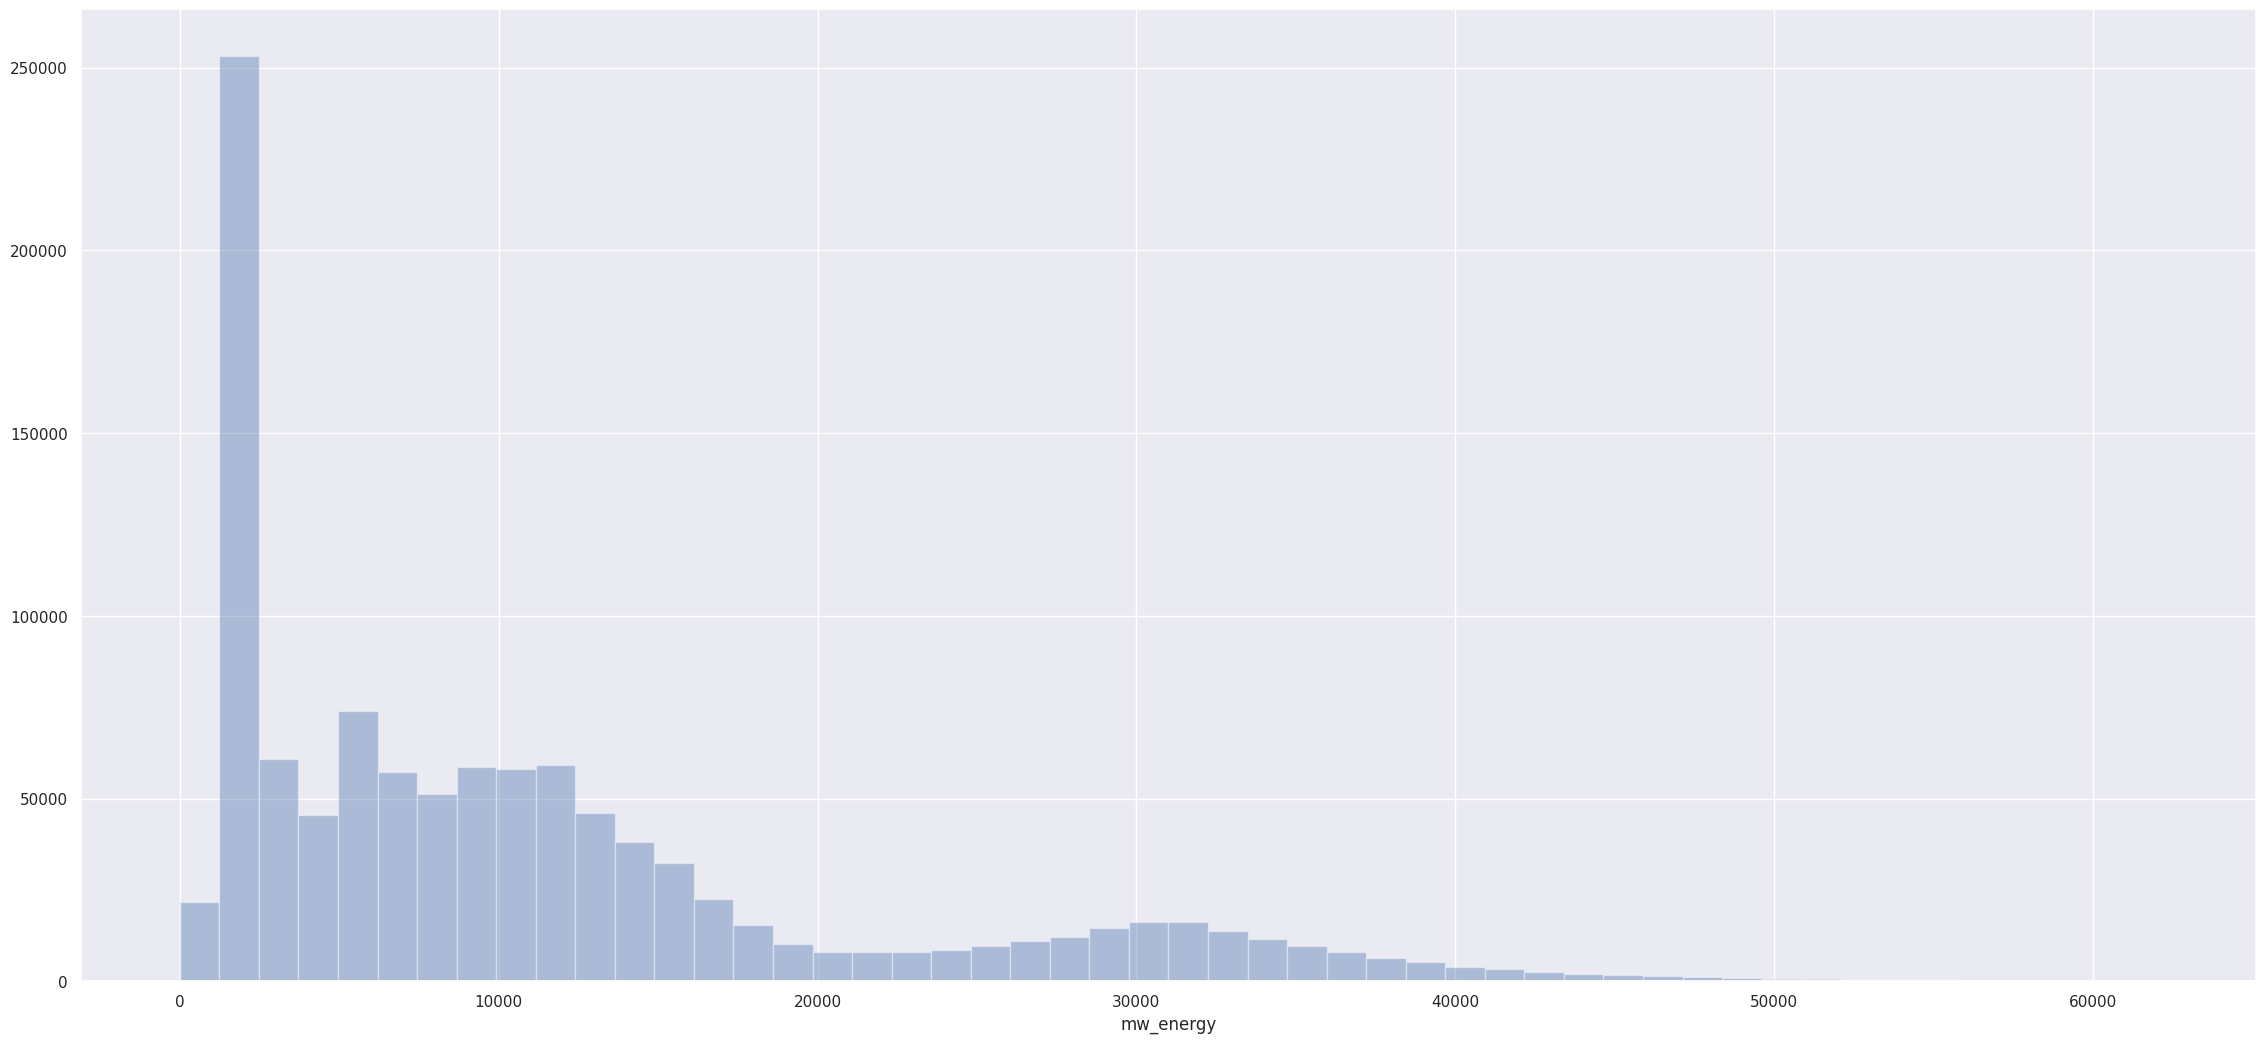

In [ ]:
# Considering energy consumption column to be my response variable
sns.distplot(df_eda['mw_energy'], kde=False)

array([[<Axes: title={'center': 'mw_energy'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'hour'}>],
       [<Axes: title={'center': 'day_of_week'}>, <Axes: >]], dtype=object)

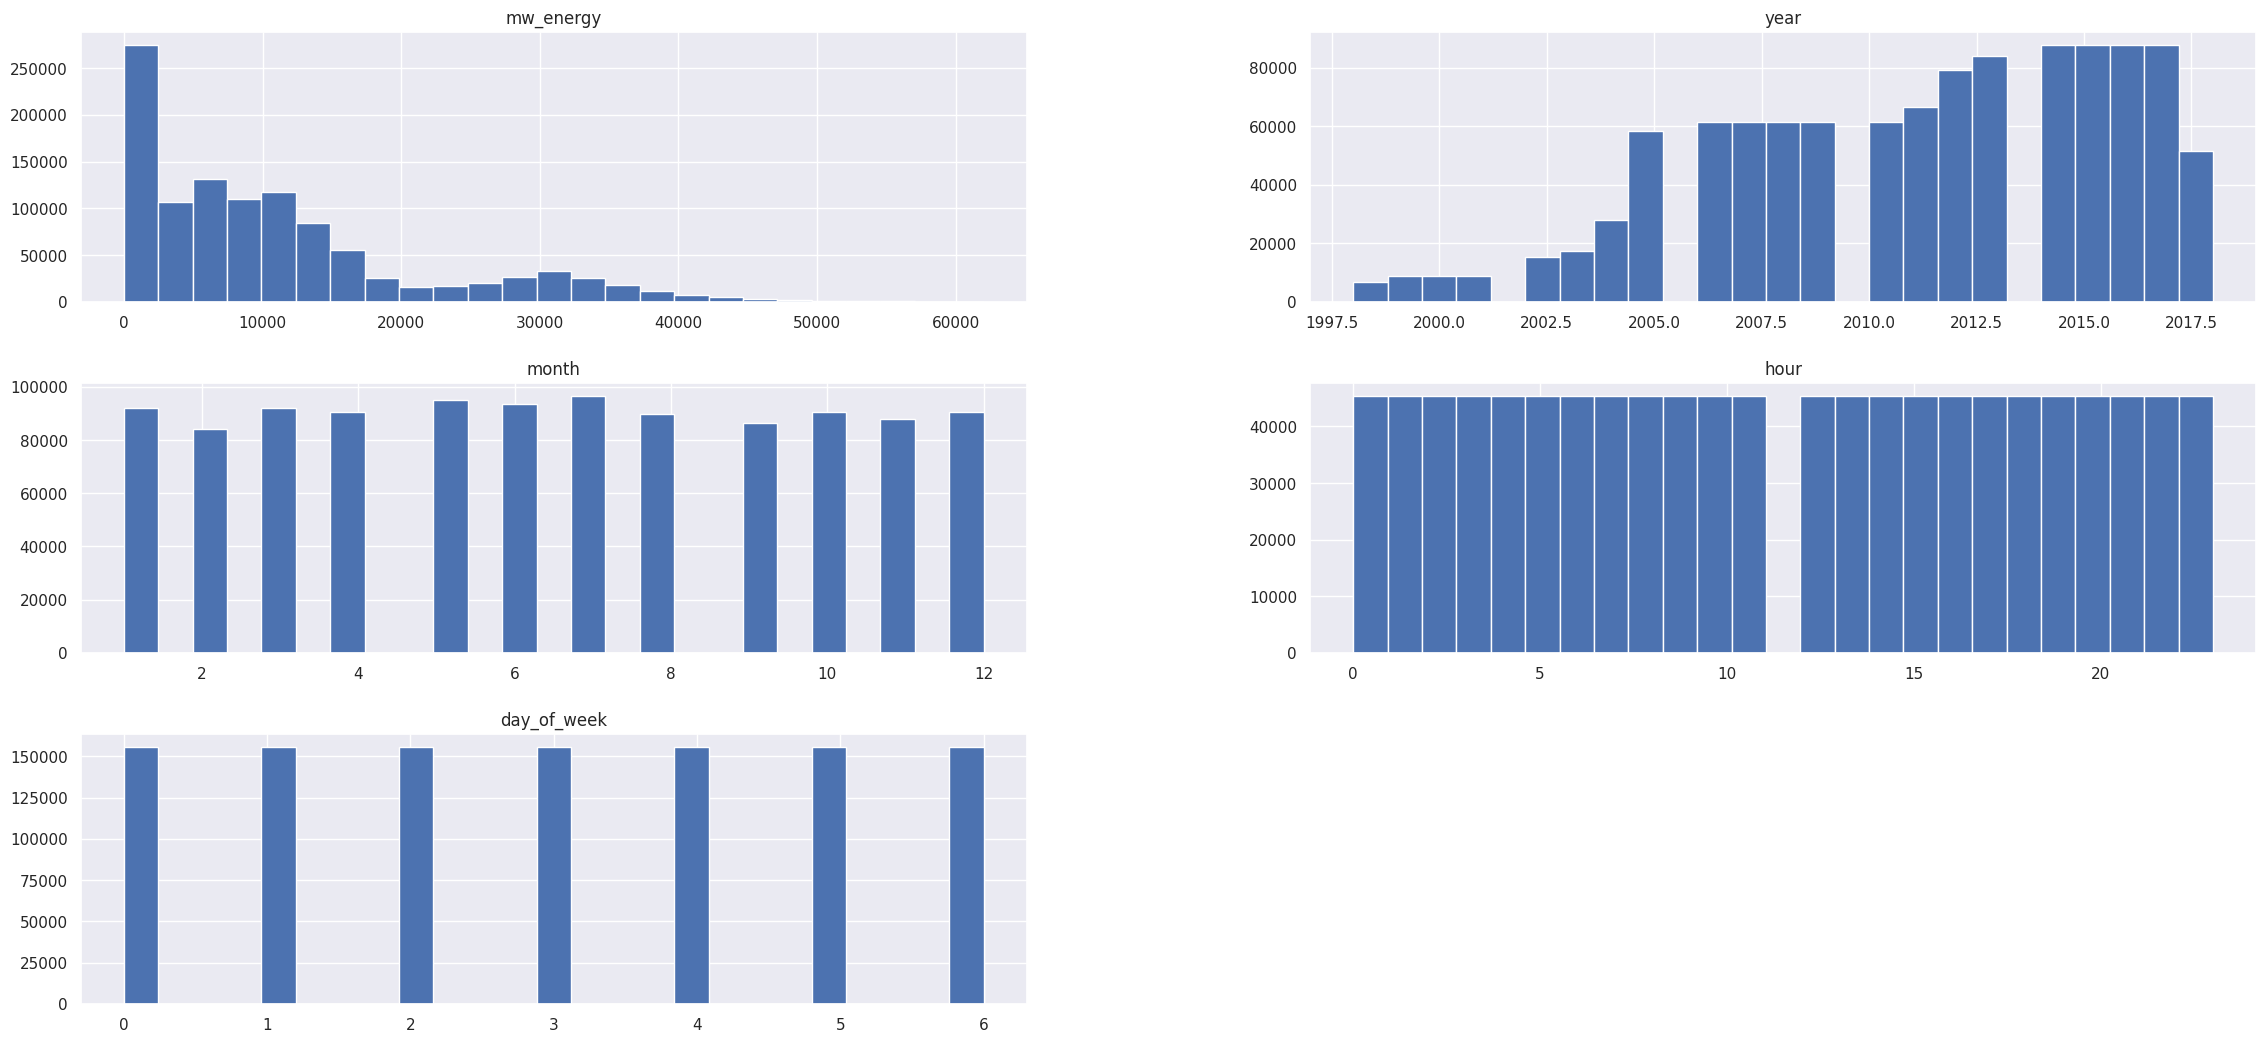

In [ ]:
# Exploring distribution of the numerical features
num_features2.hist(bins=25)

In [ ]:
# Checking categorical features
cat_features2.head()

,electric_company,season,holidays
0,AEP,Winter,Holiday
1,AEP,Winter,Holiday
2,AEP,Winter,Holiday
3,AEP,Winter,Holiday
4,AEP,Winter,Holiday


In [ ]:
# drop duplicates
df_eda['electric_company'].drop_duplicates()

,electric_company
0,AEP
0,COMED
0,DAYTON
0,DEOK
0,DOM
0,DUQ
0,EKPC
0,FE
0,NI
0,PJM


In [ ]:
# drop season duplicates
df_eda['season'].drop_duplicates()

,season
0,Winter
744,Autumn
5134,Summer
7342,Spring


In [ ]:
# drop holidays duplicates
df_eda['holidays'].drop_duplicates()

,holidays
0,Holiday
48,Normal day


> ▶ Analysing the categorical features and relation to energy consumption

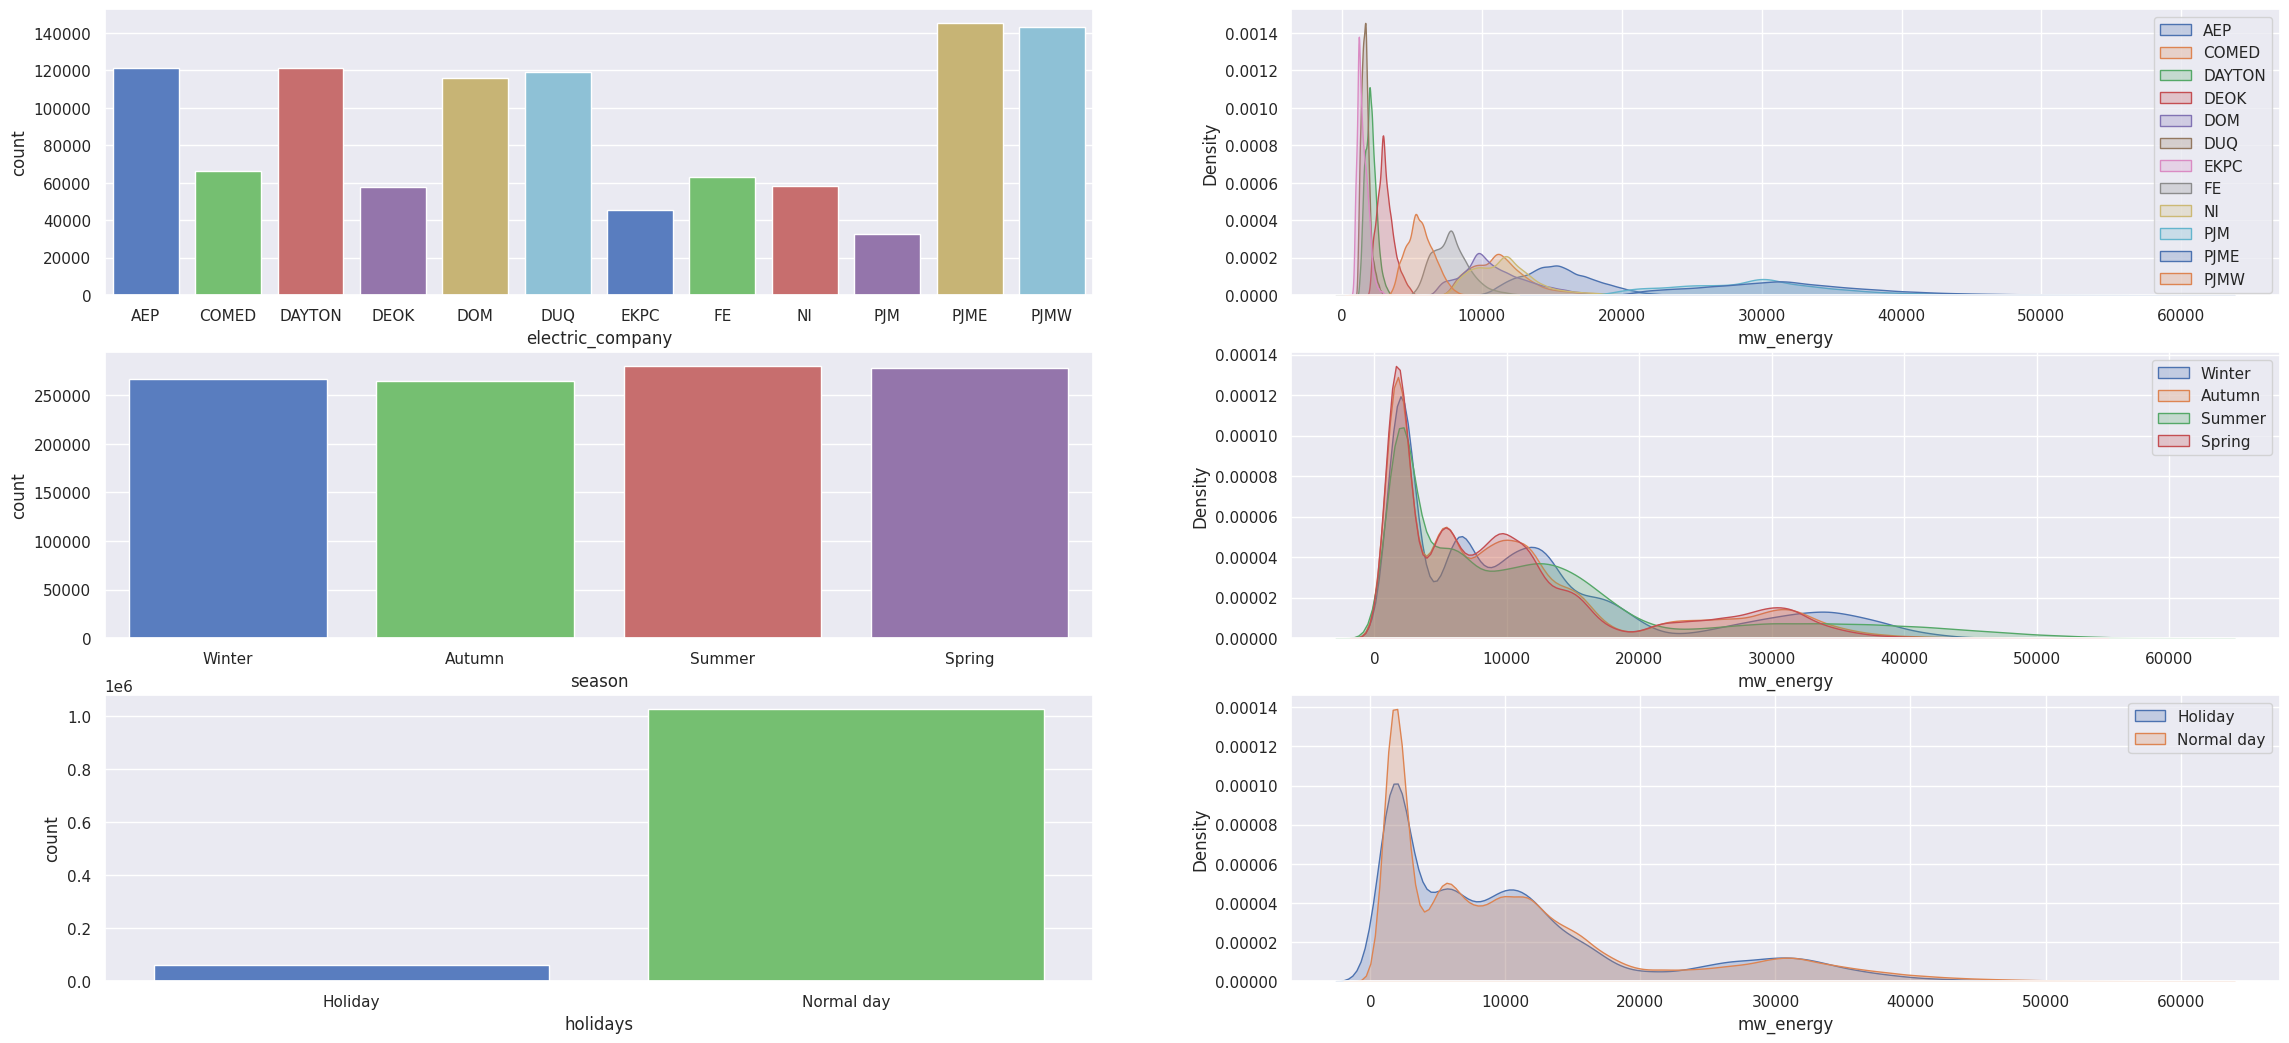

In [ ]:
plt.subplot( 3, 2, 1)
sns.countplot( x=df_eda['electric_company'], palette='muted6' )

plt.subplot( 3, 2, 2)
sns.kdeplot( df_eda[df_eda['electric_company'] == 'AEP']['mw_energy'], label='AEP', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'COMED']['mw_energy'], label='COMED', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DAYTON']['mw_energy'], label='DAYTON', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DEOK']['mw_energy'], label='DEOK', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DOM']['mw_energy'], label='DOM', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'DUQ']['mw_energy'], label='DUQ', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'EKPC']['mw_energy'], label='EKPC', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'FE']['mw_energy'], label='FE', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'NI']['mw_energy'], label='NI', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'PJM']['mw_energy'], label='PJM', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'PJME']['mw_energy'], label='PJME', shade=True )
sns.kdeplot( df_eda[df_eda['electric_company'] == 'PJMW']['mw_energy'], label='PJMW', shade=True )
plt.legend()
# season

plt.subplot( 3, 2, 3)
sns.countplot( x= df_eda['season'], palette='muted6' )

plt.subplot( 3, 2, 4)
sns.kdeplot( df_eda[df_eda['season'] == 'Winter']['mw_energy'], label='Winter', shade=True )
sns.kdeplot( df_eda[df_eda['season'] == 'Autumn']['mw_energy'], label='Autumn', shade=True )
sns.kdeplot( df_eda[df_eda['season'] == 'Summer']['mw_energy'], label='Summer', shade=True )
sns.kdeplot( df_eda[df_eda['season'] == 'Spring']['mw_energy'], label='Spring', shade=True )
plt.legend()

# holidays
plt.subplot( 3, 2, 5)
sns.countplot( x=df_eda['holidays'], palette='muted6' )

plt.subplot( 3, 2, 6)
sns.kdeplot( df_eda[df_eda['holidays'] == 'Holiday']['mw_energy'], label='Holiday', shade=True )
sns.kdeplot( df_eda[df_eda['holidays'] == 'Normal day']['mw_energy'], label='Normal day', shade=True )

plt.legend()

###  🔦 EDA - Part 2: Bivariate Analysis
- Energy consumption at different times of the day

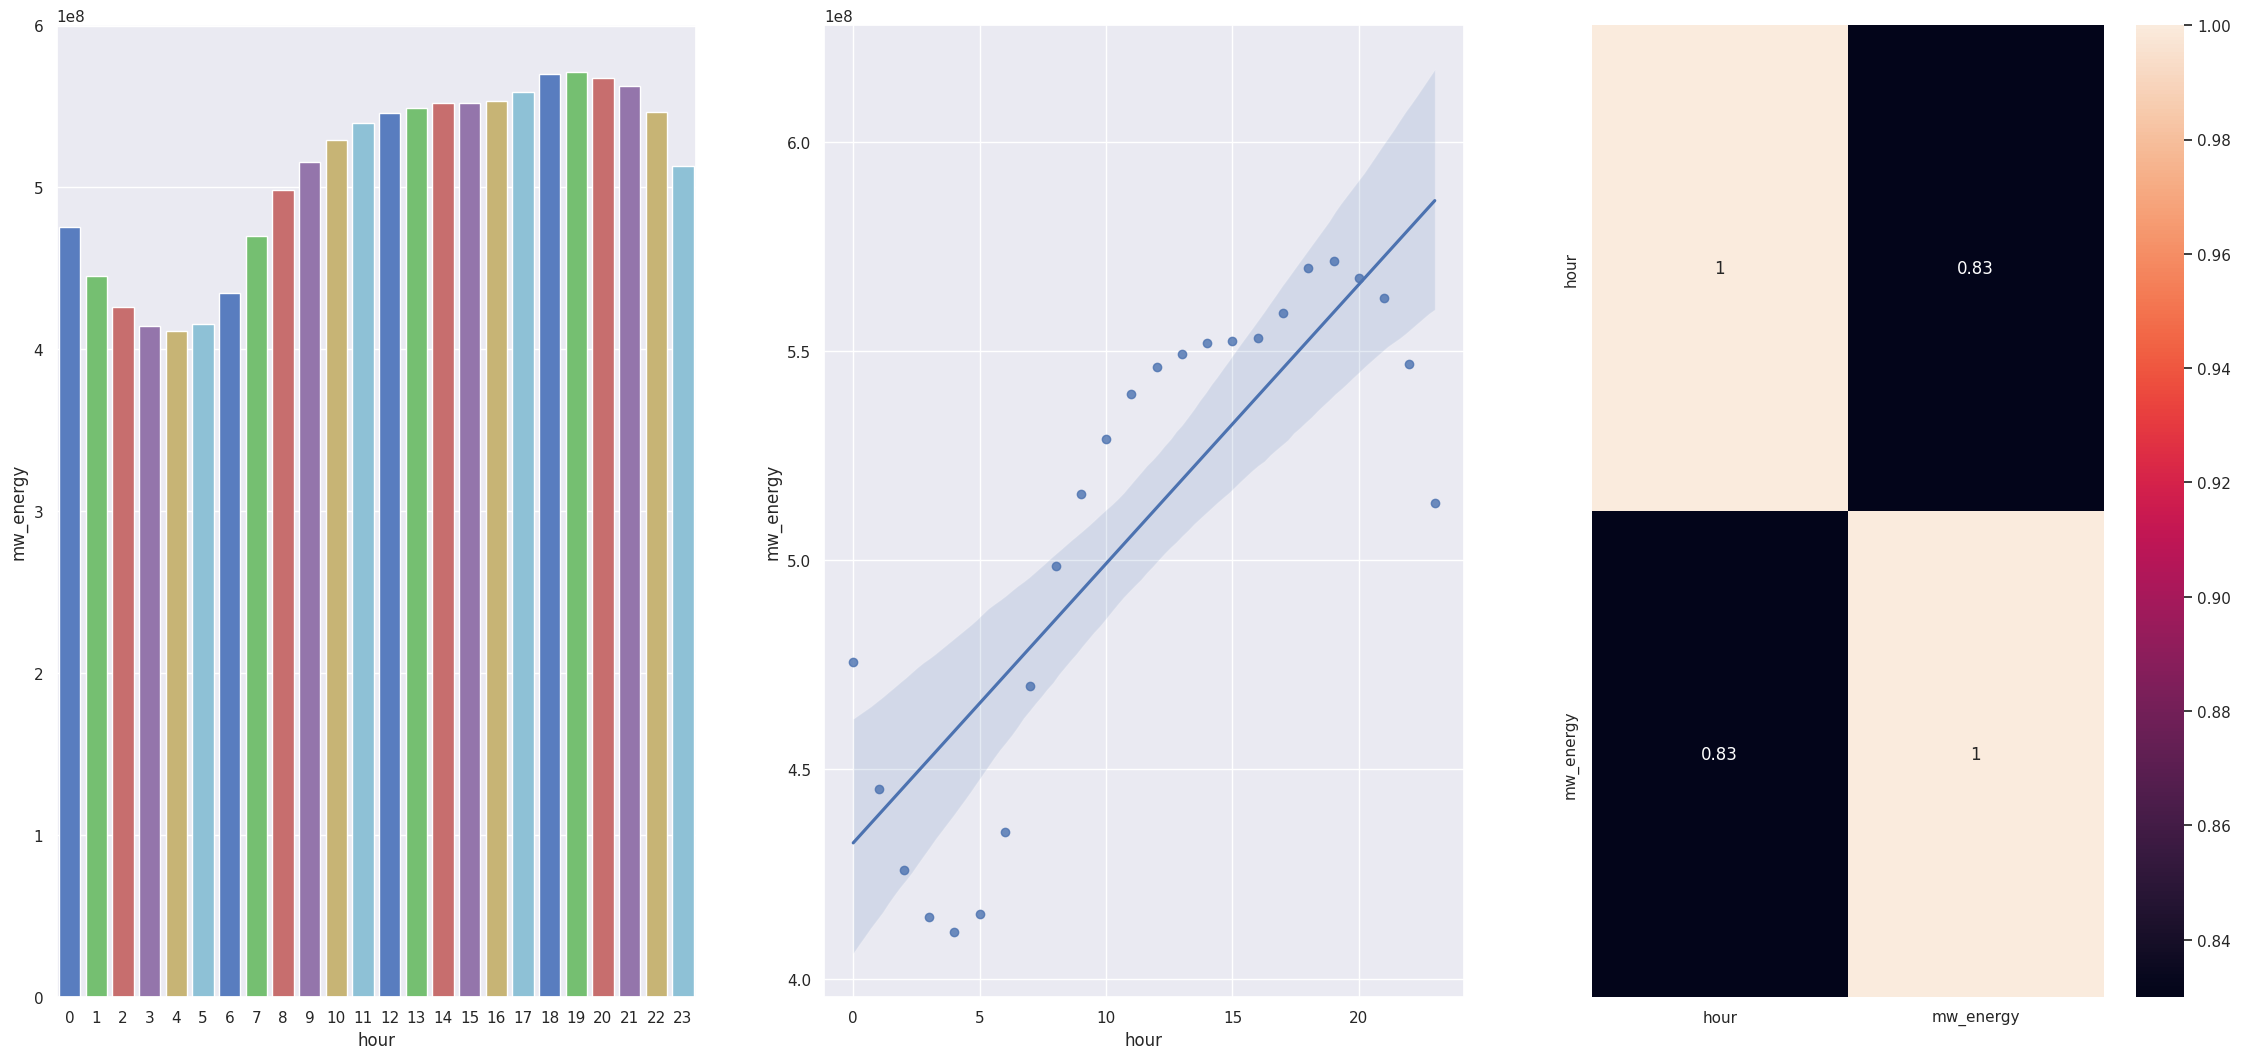

In [ ]:
plt.subplot(1,3,1)
d1 = df_eda[['hour', 'mw_energy']].groupby( 'hour' ).sum().reset_index()
sns.barplot( x='hour', y='mw_energy', data=d1, palette='muted6')

plt.subplot(1,3,2)
sns.regplot( x='hour', y='mw_energy', data=d1 )

plt.subplot(1,3,3)
sns.heatmap( d1.corr( method='pearson' ), annot=True );

#### 💡 Observations and Inference:
> - From the bar plot on the left we seee that energy consumption peaks early morning and rises to its peak around the evening hours
> - Least energy consumption is witnessed during post midnight
> - The regression plot and pearson correlation show a strong positive correlation between the hour of the day and the energy consumptions

#### 🎯 Energy consumption across seasons

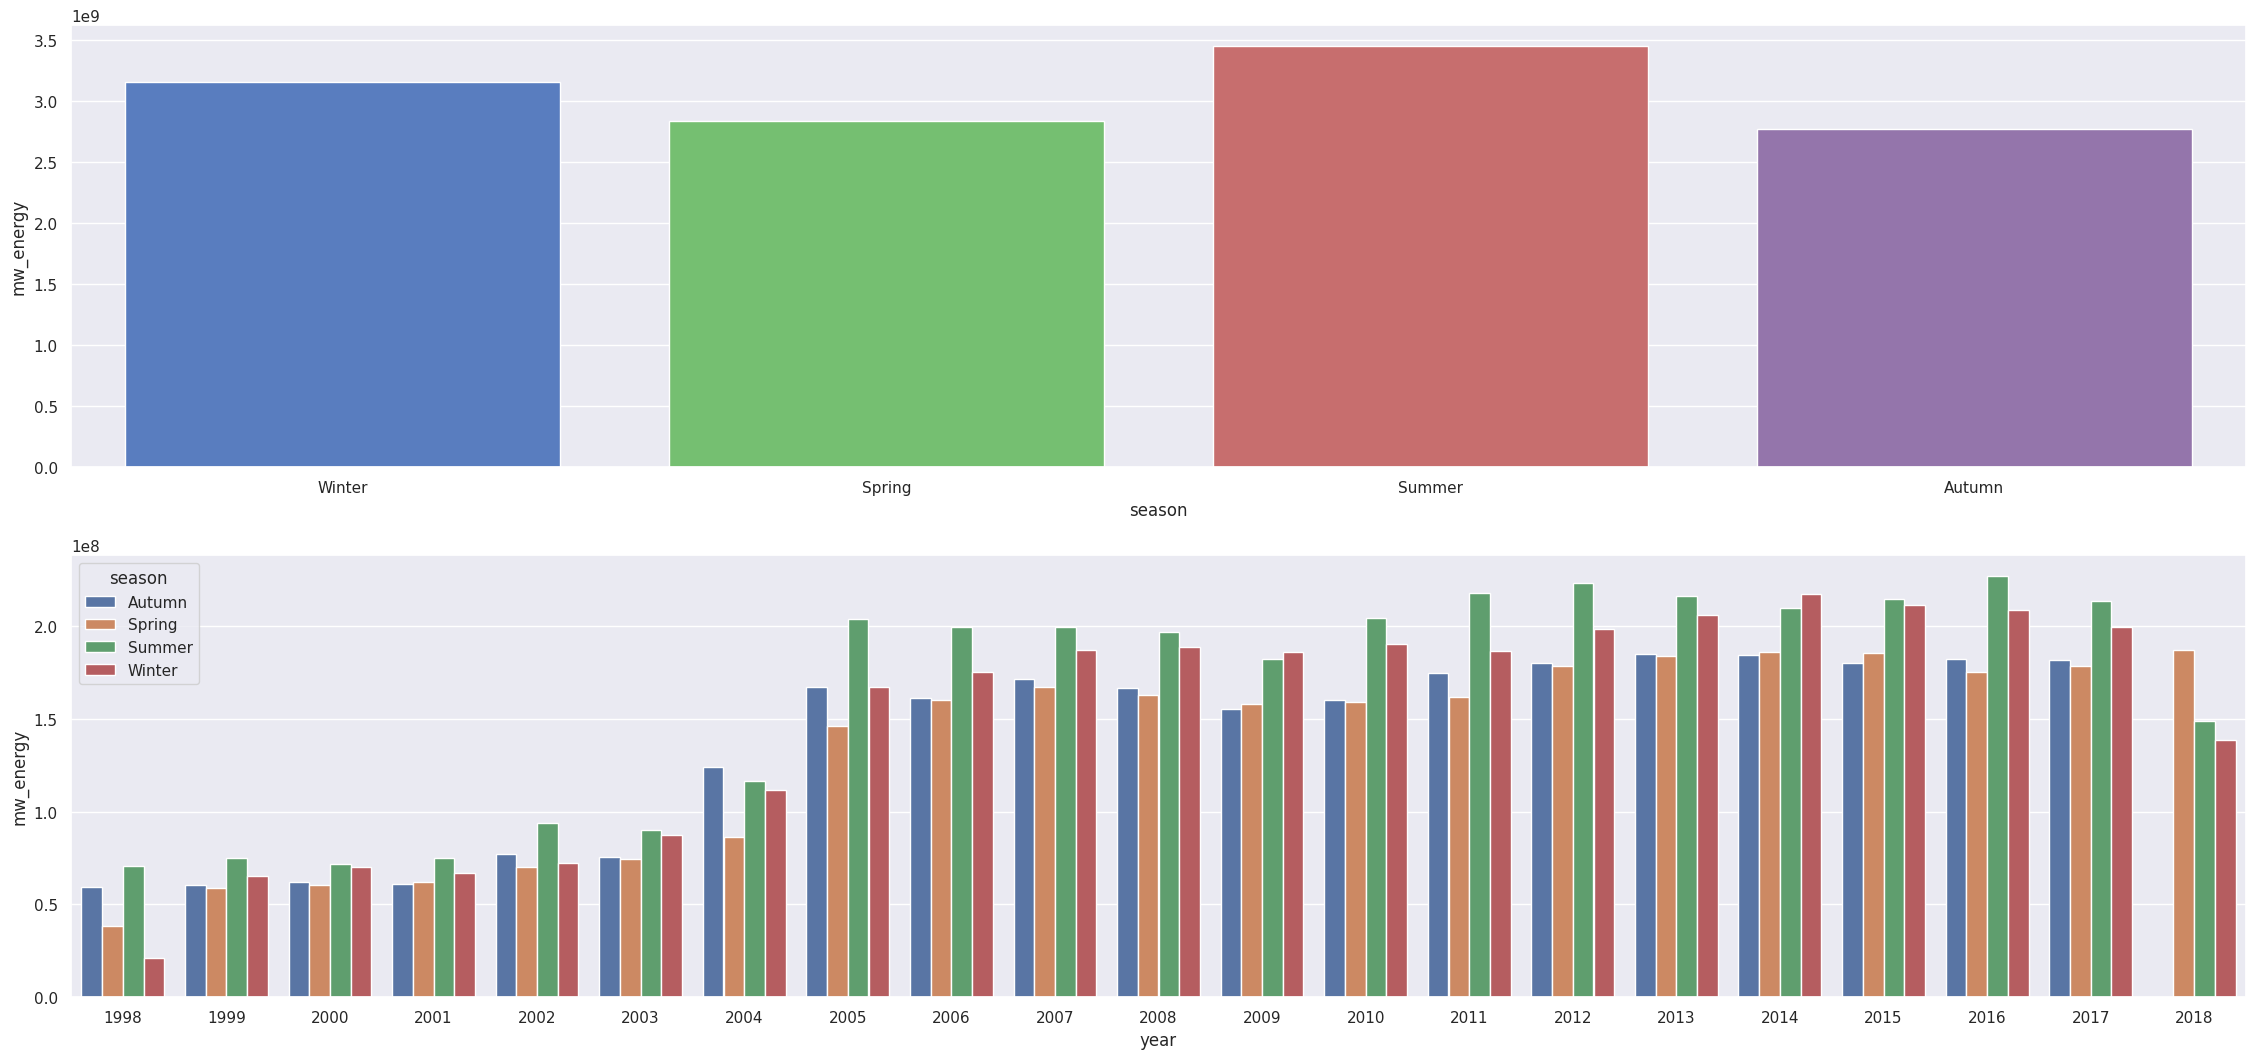

In [ ]:
d1 = df_eda[['season', 'mw_energy']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='season', y='mw_energy', data=d1, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette='muted6' )

d2 = df_eda[['year', 'season', 'mw_energy']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy', hue='season', data=d2, orient='v');

#### 💡 Observations and Inference:
> * Energy consumption is highest during winters and summers across the datasets
> * The rise of energy demands becomes very evdient when we spread out the seasonal energy consumption over the years from 1998 to 2018

#### 🎯 Energy consumption across federal holidays


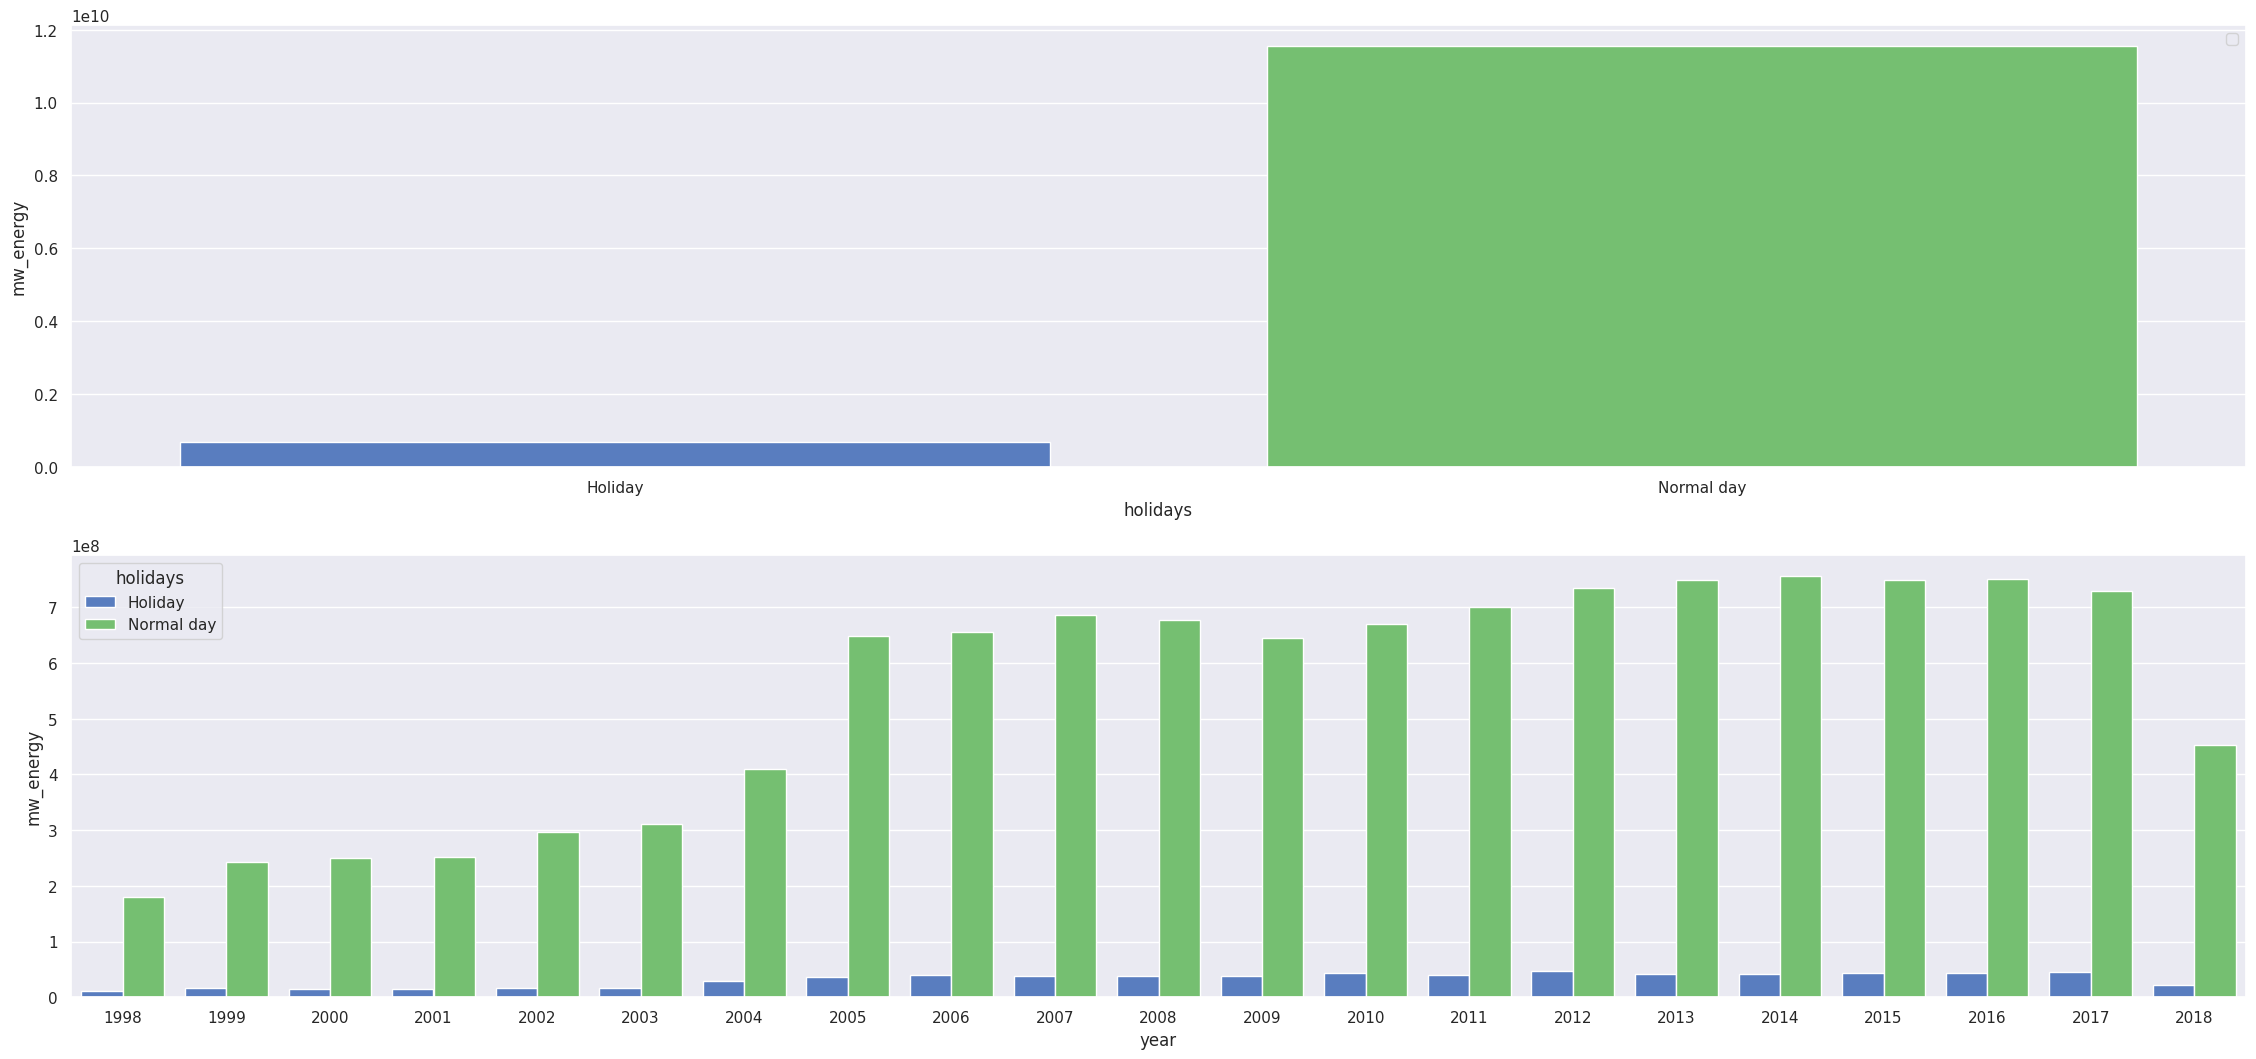

In [ ]:
d1 = df_eda[['holidays', 'mw_energy']].groupby( 'holidays' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='mw_energy', data=d1, palette='muted6' )
plt.legend()

d2 = df_eda[['year', 'holidays', 'mw_energy']].groupby( ['year', 'holidays'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='mw_energy', hue='holidays', data=d2, palette='muted6' );

#### 💡 Observations and Inference:
> * Energy consumption contrary to usual hypothesis is much higher during workdays then holidays
> * Here too when we plot this distribution across the years we see how significant workday energy consumption is compared to holidays.
> * An intersting Article [Holiday Power Consumption](https://www.eia.gov/todayinenergy/detail.php?id=37572&src=email) that verifies the analysis further

###  🔦 EDA - Part 3: Multivariate Analysis

#### 🎯 Energy consumption correlation across all the numerical time series features

<Axes: >

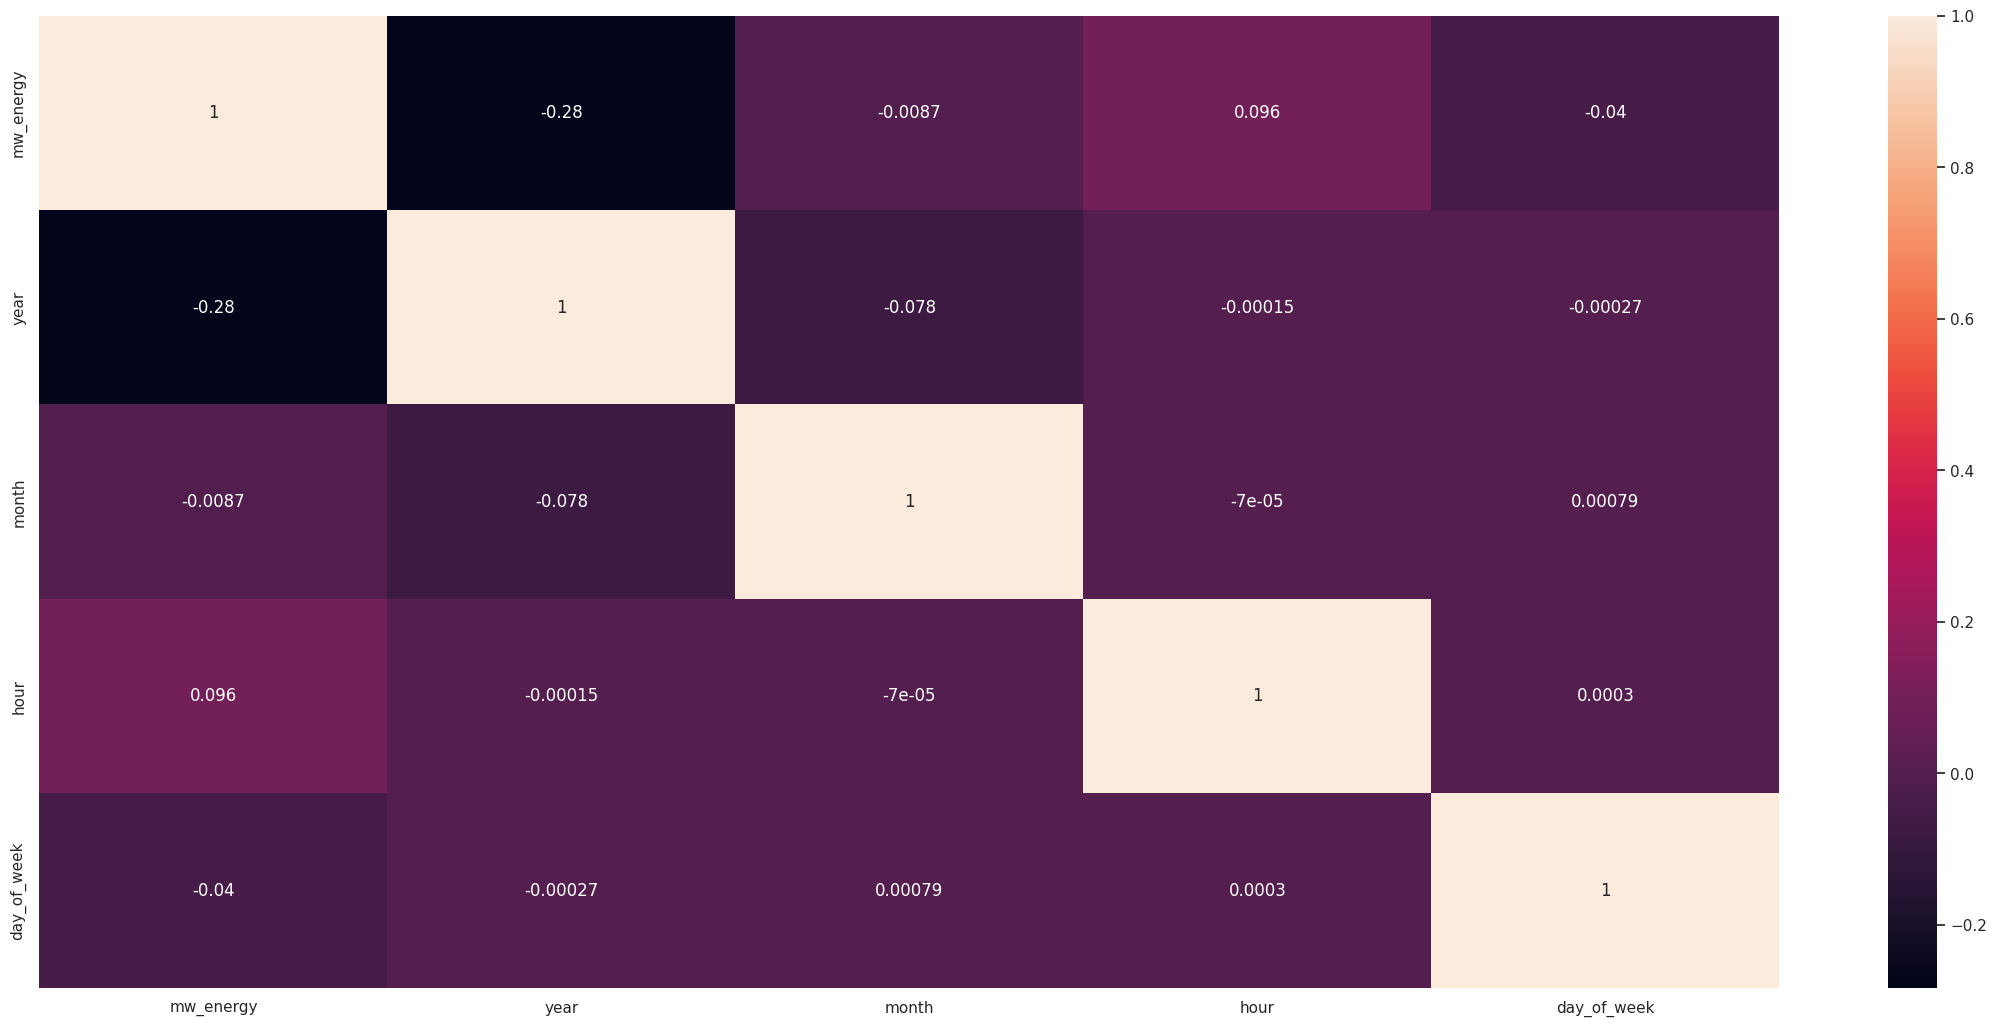

In [ ]:
correlation = num_features2.corr( method='pearson' )
sns.heatmap( correlation, annot=True )


#### 💡 Observations and Inference:
> * Year and month don't seem to have a strong relationship with energy consumption

#### 🎯 Energy consumption correlation across all the categorical time series features

* Below code creates the contingency table using cross tab

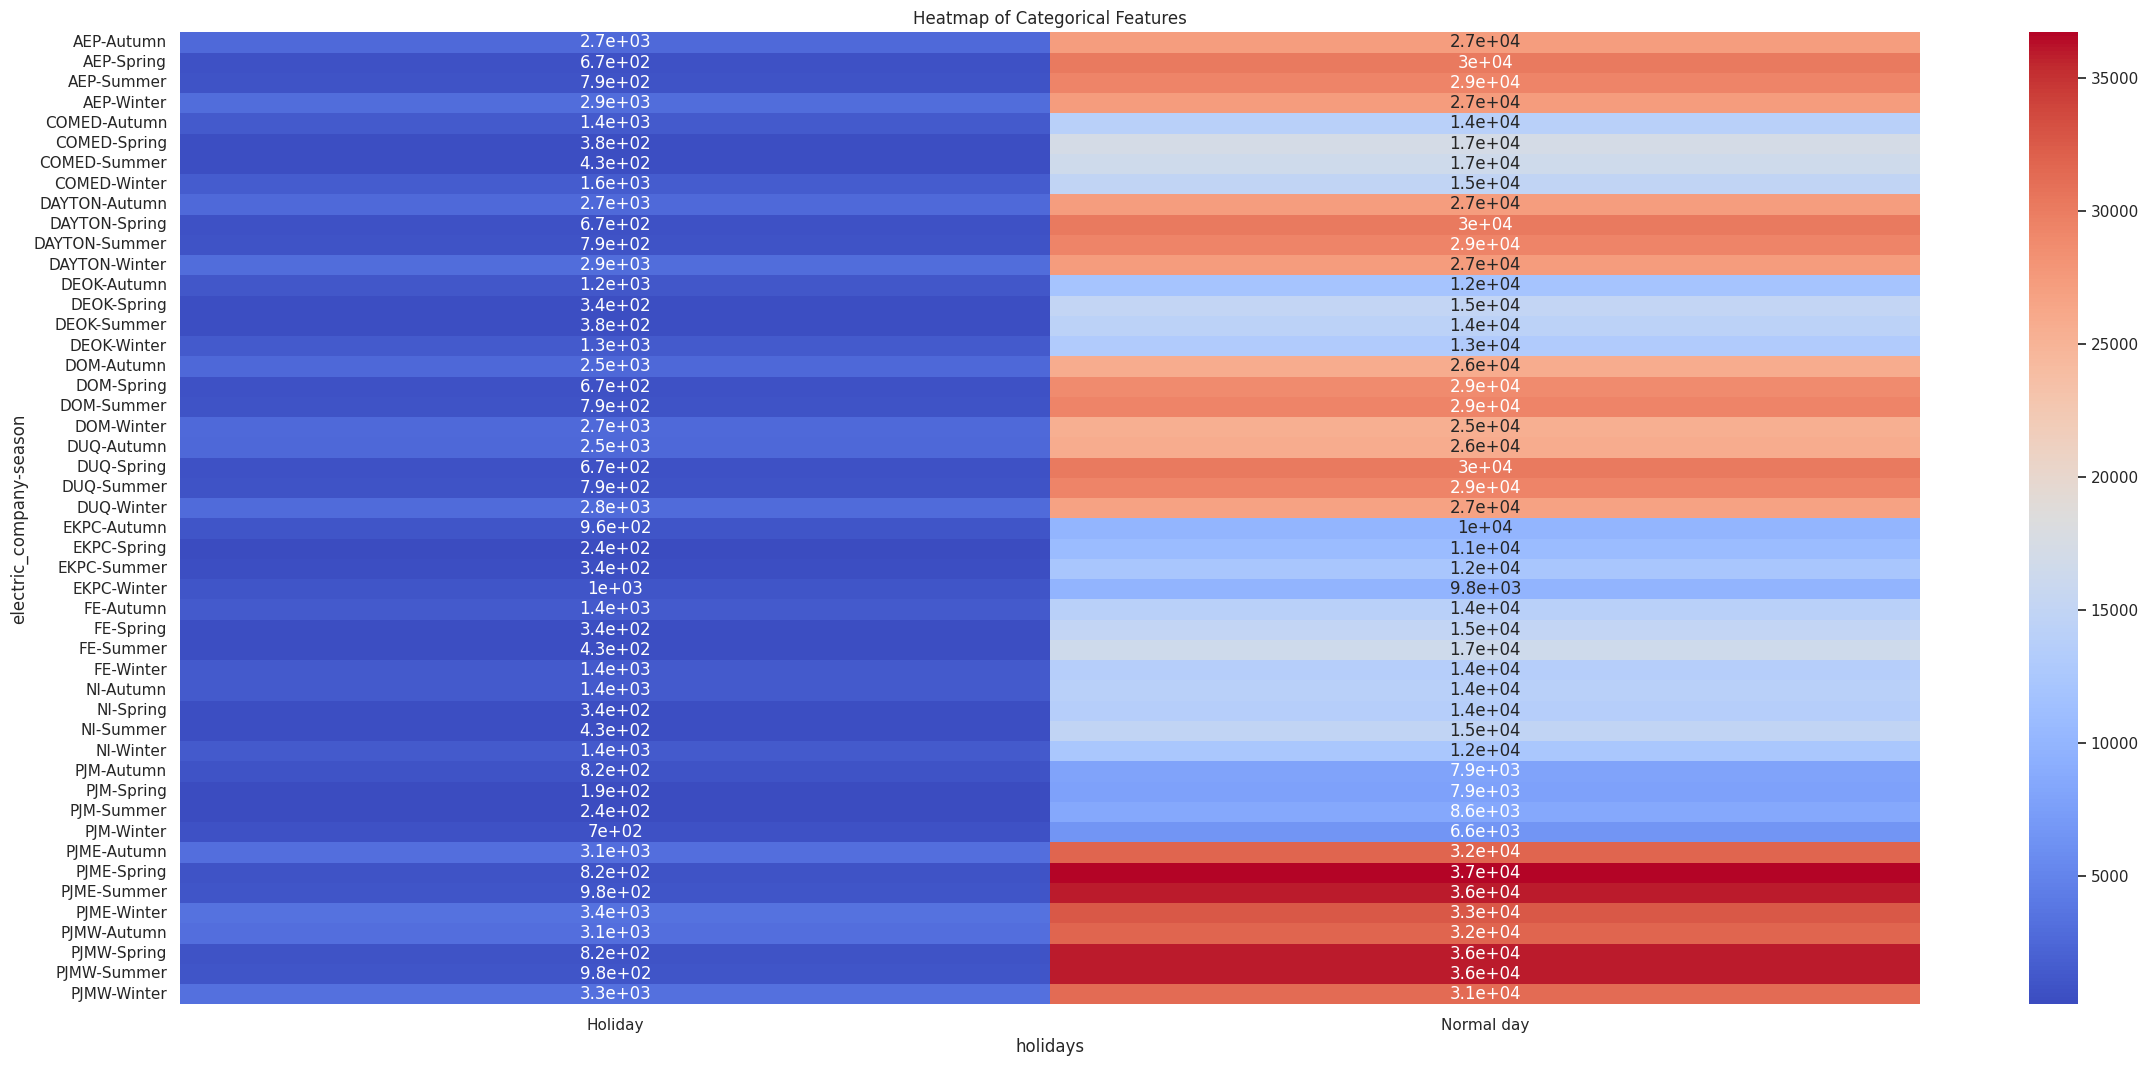

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(index=[cat_features2['electric_company'],cat_features2['season']], columns=cat_features2['holidays'])

# Plot the heatmap
sns.heatmap(contingency_table, annot=True, cmap='coolwarm')
plt.title("Heatmap of Categorical Features")
plt.show()

# 4. 🤖 Predictive Modeling

> - The goal in this stage of the project is to model the energy consumption data to be able to forecast it's future demand

> - In order to do so we will explore two companies in particular 1. **ComED** and **Dominion**

> - The algorithms we will experiment with include **Xgboost**, **Prophet** and **RNN-LSTM**

## Modeling ComED Energy Consumption

In [2]:
# Selecting ComED data from this dataset
df_comed = pd.read_csv('/content/COMED_hourly.csv')

# Set index to Datetime
df_comed = df_comed.set_index('Datetime')
df_comed.index = pd.to_datetime(df_comed.index)

In [5]:
# Observe the data frame
df_comed.head(10)

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0
2011-12-31 06:00:00,8735.0
2011-12-31 07:00:00,8993.0
2011-12-31 08:00:00,9363.0
2011-12-31 09:00:00,9545.0


In [6]:
df_comed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66497 entries, 2011-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   COMED_MW  66497 non-null  float64
dtypes: float64(1)
memory usage: 1.0 MB


> #### ▶ WE will try to see how the data looks when split into Trend, Sesonality and Residual components

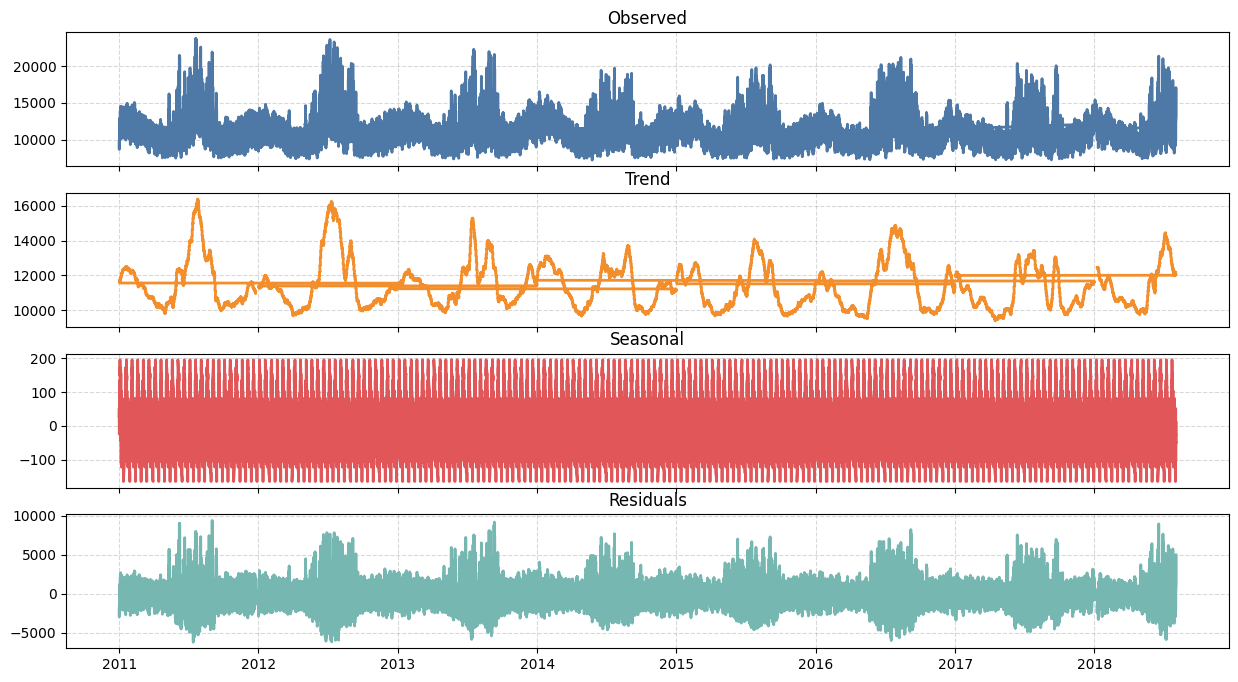

In [18]:
# Extract the Energy consumption column 'mw_energy'
mw_energy_series = df_comed

# Intitate seasonal decomposition
result = seasonal_decompose(mw_energy_series, model='additive', period=365)


# Manually plot each component
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

# Use a unique, visually appealing color palette
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']  # Example palette

# Observed
axes[0].plot(result.observed, color=colors[0], linewidth=2)
axes[0].set_title('Observed', fontsize=12)
axes[0].grid(color='gray', linestyle='--', alpha=0.3)

# Trend
axes[1].plot(result.trend, color=colors[1], linewidth=2)
axes[1].set_title('Trend', fontsize=12)
axes[1].grid(color='gray', linestyle='--', alpha=0.3)

# Seasonal
axes[2].plot(result.seasonal, color=colors[2], linewidth=2)
axes[2].set_title('Seasonal', fontsize=12)
axes[2].grid(color='gray', linestyle='--', alpha=0.3)

# Residuals
axes[3].plot(result.resid, color=colors[3], linewidth=2)
axes[3].set_title('Residuals', fontsize=12)
axes[3].grid(color='gray', linestyle='--', alpha=0.3)

# Adjust layout for better spacing
#plt.tight_layout()
plt.show()


#### 💡 Observations and Inference:
> - **Observed** plot with spikes at certain interval points to us of some cyclic nature in the power consumption over the years.
> - **Trend** plot of the time series does not observe any distinct increasing or decreasing trend in the data.
> - **Seasonal** component shows repetitive patterns at regular intervals these could be a result of dail, weekly or monthly patterns.



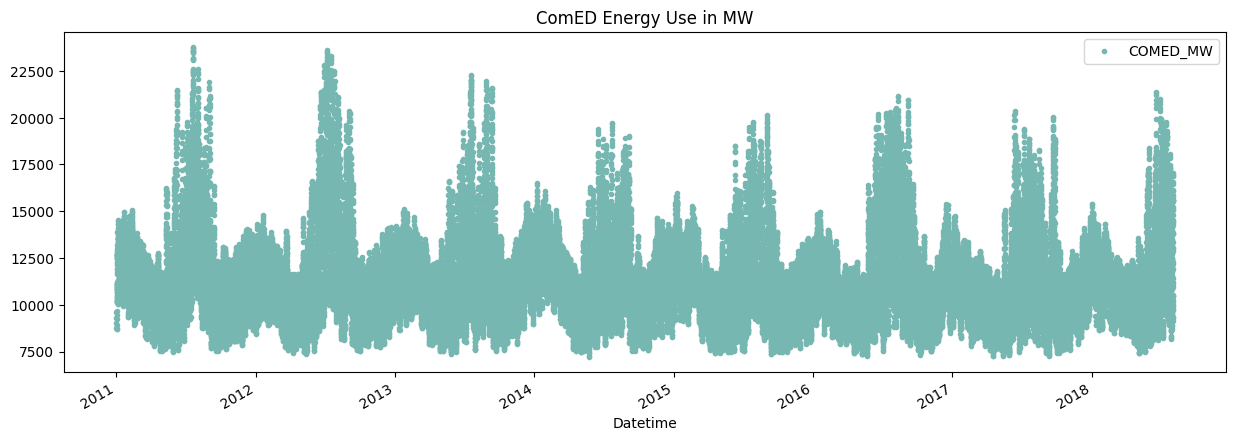

In [19]:
# Plotting the ComED data

df_comed.plot(style='.',
        figsize=(15, 5),
        color='#76B7B2',
        title='ComED Energy Use in MW')
plt.show()

### 📚 ➡️ 🧠 ➡️ 🧪   Splitting the Data into Train and Test Sets

- The Train split will contains data up until 01-01-2014
- The Test split will contain data post 01-01-2014

In [3]:
# Create a dataframe only selecting the ComED energy consumption column
df_comed_energy = df_comed.copy()

In [4]:
df_comed_energy.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


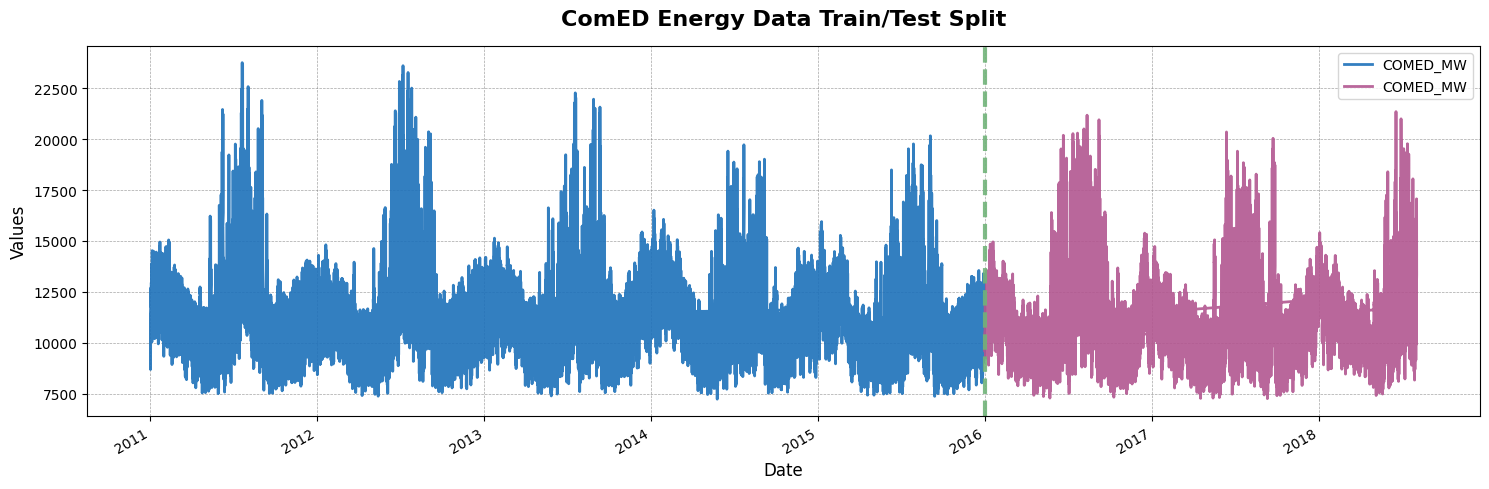

In [21]:
comed_train_df = df_comed_energy[df_comed_energy.index < '01-01-2016']
comed_test_df = df_comed_energy[df_comed_energy.index >= '01-01-2016']

# Create the figure and axis with a clean, elegant style
fig, ax = plt.subplots(figsize=(15, 5))

# Use professional and well-praised color palette
train_color = '#1D71BA'  # Muted blue
test_color = '#B25690'   # Soft orange #'#6AB187'

# Plot the training set
comed_train_df.plot(ax=ax, label='Training Set', color=train_color, linewidth=2, alpha=0.9)

# Plot the test set
comed_test_df.plot(ax=ax, label='Test Set', color=test_color, linewidth=2, alpha=0.9)

# Add a vertical line to separate train and test sets
ax.axvline('01-01-2016', color='#71B379', linestyle='--', linewidth=3, alpha=0.9)  # Soft green

# Add title and labels with enhanced fonts
ax.set_title('ComED Energy Data Train/Test Split', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Values', fontsize=12)

# Add gridlines for better readability
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with a subtle yet clear style
ax.legend()

# Display the final plot
plt.tight_layout()
plt.show()


### &#x2211;  🧮 FUNCTION: Generating time series features from the dataframe

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_comed_energy = create_features(df_comed)

In [4]:
df_comed_energy.head()

,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2011-12-31 01:00:00,9970.0,1,5,4,12,2011,365,31,52
2011-12-31 02:00:00,9428.0,2,5,4,12,2011,365,31,52
2011-12-31 03:00:00,9059.0,3,5,4,12,2011,365,31,52
2011-12-31 04:00:00,8817.0,4,5,4,12,2011,365,31,52
2011-12-31 05:00:00,8743.0,5,5,4,12,2011,365,31,52


Observing realtion between Energy and Time features

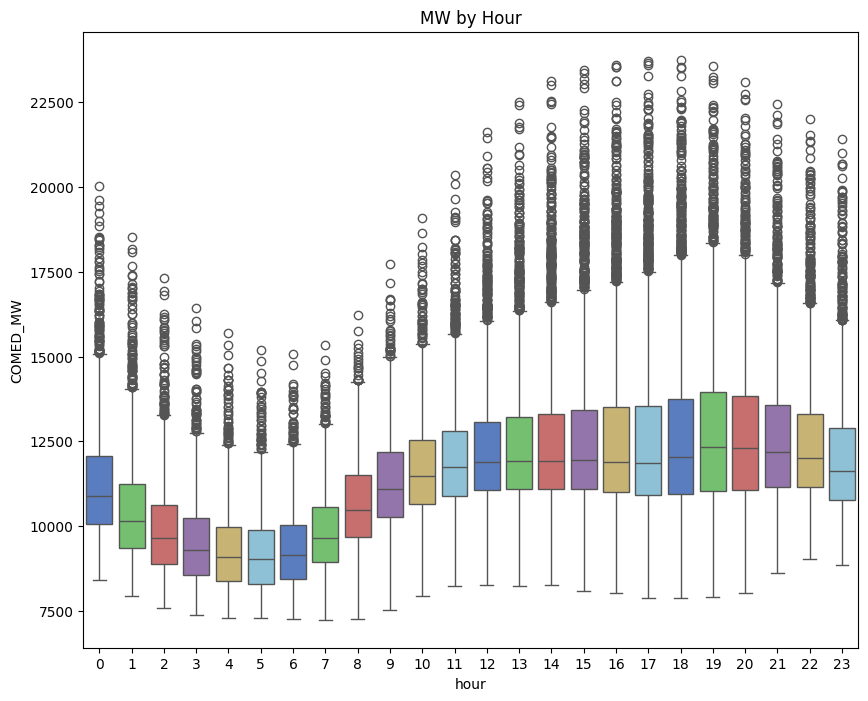

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_comed_energy, x='hour', y='COMED_MW', palette='muted6')
ax.set_title('MW by Hour')
plt.show()

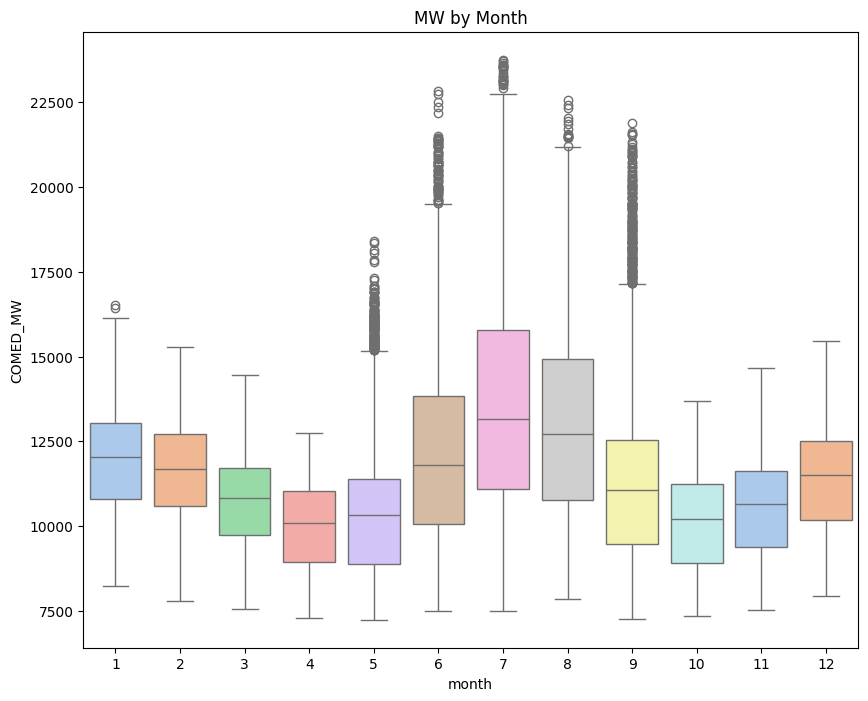

In [29]:
#  Monthly relation
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_comed_energy, x='month', y='COMED_MW', palette='pastel')
ax.set_title('MW by Month')
plt.show()

### 🧠🤖 Machine Learning Modeling With XGboost

In [31]:
df_comed_energy.columns

Index(['COMED_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [8]:
comed_train_df = df_comed_energy[df_comed_energy.index < '01-01-2016']
comed_test_df = df_comed_energy[df_comed_energy.index >= '01-01-2016']


In [10]:
train= create_features(comed_train_df)
test = create_features(comed_test_df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'COMED_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [49]:
test.head()

,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2016-01-01 00:00:00,10802.0,0,4,1,1,2016,1,1,53
2016-12-31 01:00:00,10419.0,1,5,4,12,2016,366,31,52
2016-12-31 02:00:00,9940.0,2,5,4,12,2016,366,31,52
2016-12-31 03:00:00,9604.0,3,5,4,12,2016,366,31,52
2016-12-31 04:00:00,9318.0,4,5,4,12,2016,366,31,52


In [50]:
# Initialize XGBoost Regressor
xgboost_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

# Fit the model
xgboost_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Predict on the test set
y_pred = xgboost_reg.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


[0]	validation_0-rmse:11602.28491	validation_1-rmse:11404.54123
[100]	validation_0-rmse:4497.42234	validation_1-rmse:4299.00998
[200]	validation_0-rmse:2120.64315	validation_1-rmse:1996.70767
[300]	validation_0-rmse:1453.36432	validation_1-rmse:1491.52584
[400]	validation_0-rmse:1292.40205	validation_1-rmse:1426.20553
[500]	validation_0-rmse:1236.88217	validation_1-rmse:1407.69800
[600]	validation_0-rmse:1199.46766	validation_1-rmse:1397.67233
[700]	validation_0-rmse:1176.66158	validation_1-rmse:1394.68090
[800]	validation_0-rmse:1160.38737	validation_1-rmse:1393.34011
[890]	validation_0-rmse:1145.42528	validation_1-rmse:1391.08591
Mean Absolute Error (MAE): 983.42
Mean Squared Error (MSE): 1934214.25
R² Score: 0.63


### 🎯 Feature Importance

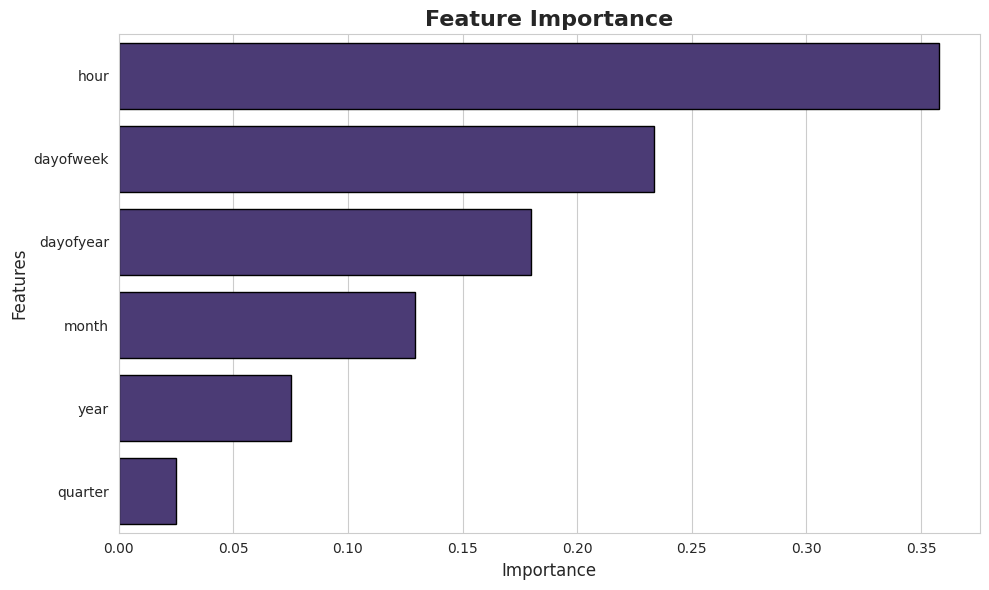

In [51]:
# Create the feature importance DataFrame
feat_imp = pd.DataFrame(
    data=xgboost_reg.feature_importances_,
    index=xgboost_reg.feature_names_in_,
    columns=['importance']
)

# Sort values by importance
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.barplot(
    x='importance',
    y=feat_imp.index,
    data=feat_imp,
    orient='h',
    edgecolor='black'
)

# Add a title and labels
plt.title("Feature Importance", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


#### 💡 Observations and Inference:
> - A look at the feature importance shows hour being the feature with most importance
> - However given the importance score for hour is 0.35 though it is the most impactful in modelling the other features such as dayofweek and dayofyear must be also contributing in the predictions.

### 📉 Forecating on Test Data

In [52]:
test.head()

,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2016-01-01 00:00:00,10802.0,0,4,1,1,2016,1,1,53
2016-12-31 01:00:00,10419.0,1,5,4,12,2016,366,31,52
2016-12-31 02:00:00,9940.0,2,5,4,12,2016,366,31,52
2016-12-31 03:00:00,9604.0,3,5,4,12,2016,366,31,52
2016-12-31 04:00:00,9318.0,4,5,4,12,2016,366,31,52


In [53]:
test['prediction'] = xgboost_reg.predict(X_test)


In [54]:
test.head()

,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2016-01-01 00:00:00,10802.0,0,4,1,1,2016,1,1,53,11392.720703
2016-12-31 01:00:00,10419.0,1,5,4,12,2016,366,31,52,10094.910156
2016-12-31 02:00:00,9940.0,2,5,4,12,2016,366,31,52,9540.418945
2016-12-31 03:00:00,9604.0,3,5,4,12,2016,366,31,52,9264.364258
2016-12-31 04:00:00,9318.0,4,5,4,12,2016,366,31,52,9144.096680


In [56]:
test = test.rename(columns={'prediction': 'test_prediction'})
df_comed_energy = df_comed_energy.merge(test[['test_prediction']], how='left', left_index=True, right_index=True)


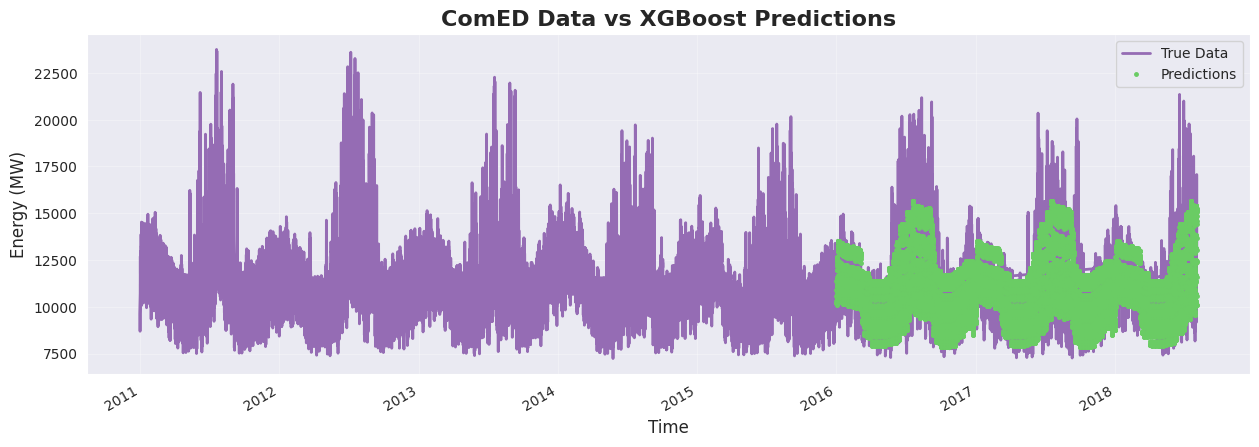

In [80]:
sns.set_style("darkgrid")
palette = sns.color_palette("muted6")

ax = df_comed_energy[['COMED_MW']].plot(figsize=(15, 5),
    ax=None,
    linestyle='-',
    linewidth=2,
    color=palette[3],
    label='Truth Data'
)

df_comed_energy['prediction'].plot(
    ax=ax,
    linestyle='None',
    marker='.',
    color=palette[1],
    markersize=5,
    label='Predictions'
)

ax.set_title("ComED Data vs XGBoost Predictions", fontsize=16, fontweight='bold')
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Energy (MW)", fontsize=12)
ax.legend(fontsize=10, loc='upper right')
plt.legend(['True Data', 'Predictions'])
# Add grid for better readability
ax.grid(alpha=0.3)
plt.show()



#### 💡 Observations and Inference:
> - The predictions by XGBoost (shown in green) seems to follow the pattern to a great degree.
> - The peaks and troughs align though the amplitude of the peaks vary and this could be attributed to inherent noise in the data.

### 🧠🤖 Time Series Machine Learning Modeling With Meta's PROPHET

In [5]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

In [6]:
# Function to set data in format acceptable to Prophet
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')

    data = data.rename(columns={'Datetime': 'ds', 'COMED_MW': 'y'})
    return data

In [12]:
df_comed_energy2 = df_comed.copy()

In [8]:
df_comed_energy2.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


In [9]:
# Before building and training our model, let's split the data into training and testing
df_train, df_test = df_comed_energy2[df_comed_energy2.index < '2016-01-01'], df_comed_energy2[df_comed_energy2.index >= '2016-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 43817
Test:	 22680


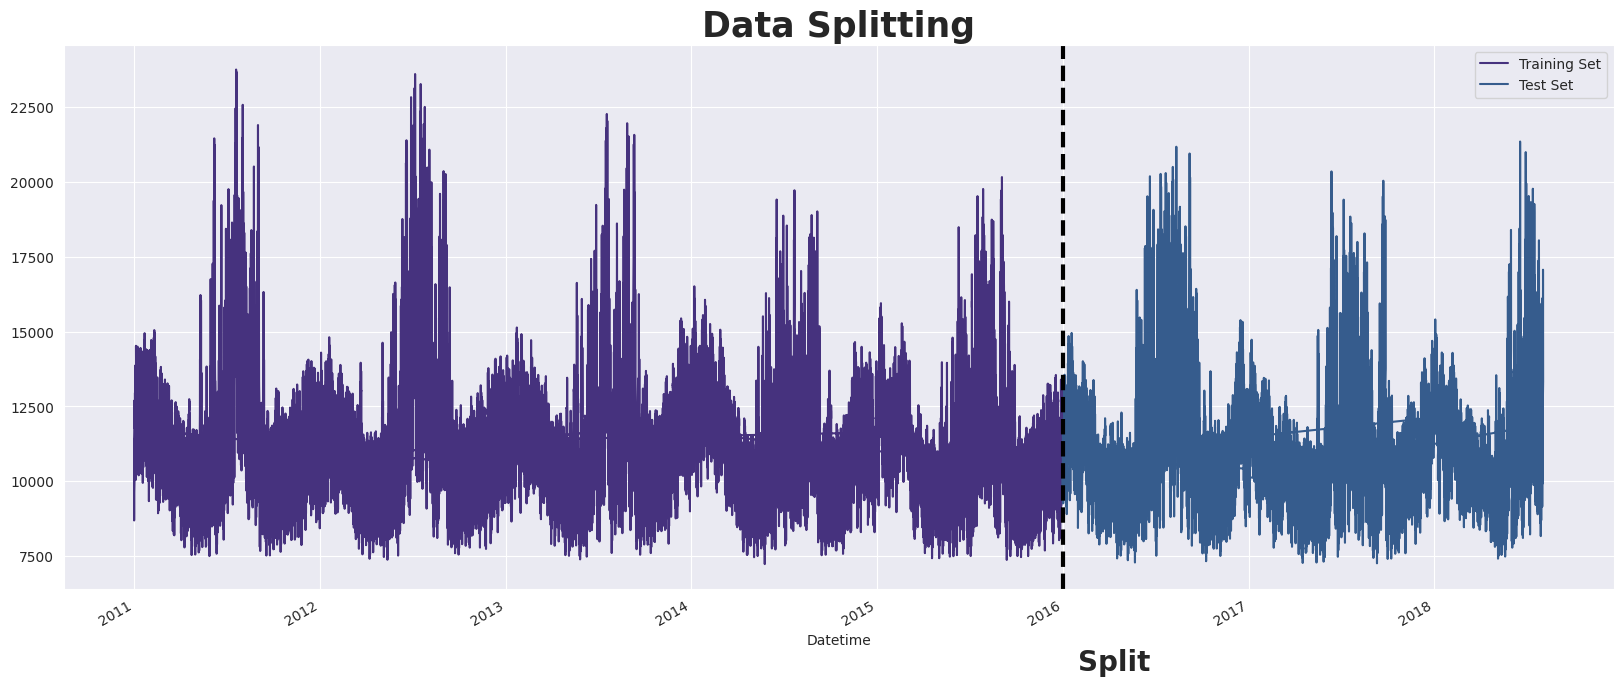

In [89]:
plt.figure(figsize=(20,8))

df_train['COMED_MW'].plot(label='Training Set')
df_test['COMED_MW'].plot(label='Test Set')
plt.axvline('2016-01-01', color='black', ls='--', lw=3)
plt.text('2016-02-01', 3700, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

In [96]:
prophet_train = index_to_column(train)
prophet_test = index_to_column(test)

In [97]:
prophet_train.head()

,ds,y,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
8734,2011-01-01 01:00:00,9631.0,1,5,1,1,2011,1,1,52
8735,2011-01-01 02:00:00,9273.0,2,5,1,1,2011,1,1,52
8736,2011-01-01 03:00:00,9011.0,3,5,1,1,2011,1,1,52
8737,2011-01-01 04:00:00,8741.0,4,5,1,1,2011,1,1,52
8738,2011-01-01 05:00:00,8694.0,5,5,1,1,2011,1,1,52


In [98]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

DEBUG:cmdstanpy:input tempfile: /tmp/tmpc61uajy5/_k1by1gy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc61uajy5/qve9baxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28330', 'data', 'file=/tmp/tmpc61uajy5/_k1by1gy.json', 'init=/tmp/tmpc61uajy5/qve9baxp.json', 'output', 'file=/tmp/tmpc61uajy5/prophet_modelpoibw2sz/prophet_model-20250323184026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### 🕟 Forecasting based on Prophet's predictions

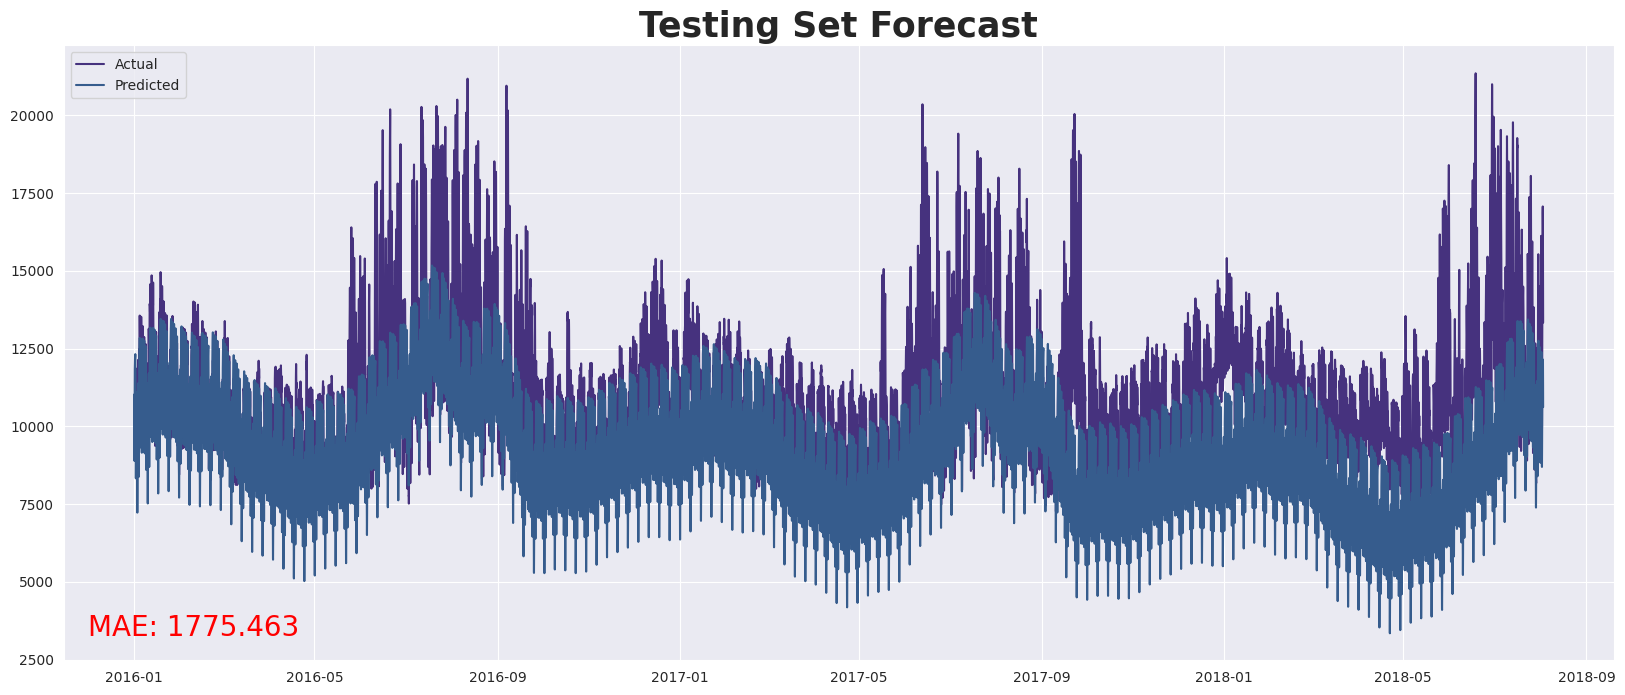

In [99]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()

#### 7 Day's Forecast

In [100]:
# This time, we will use all data (train and test) to train our model
new_df = index_to_column(df_comed_energy2)

In [101]:
new_df.head()

,ds,y
8734,2011-01-01 01:00:00,9631.0
8735,2011-01-01 02:00:00,9273.0
8736,2011-01-01 03:00:00,9011.0
8737,2011-01-01 04:00:00,8741.0
8738,2011-01-01 05:00:00,8694.0


In [102]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 7 days to the future (7x24 = 168)
future_dates = prophet_model2.make_future_dataframe(periods=168, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpc61uajy5/20np_7u1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc61uajy5/yw5xawag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7200', 'data', 'file=/tmp/tmpc61uajy5/20np_7u1.json', 'init=/tmp/tmpc61uajy5/yw5xawag.json', 'output', 'file=/tmp/tmpc61uajy5/prophet_model3iqfz08i/prophet_model-20250323184417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 2000x800 with 0 Axes>

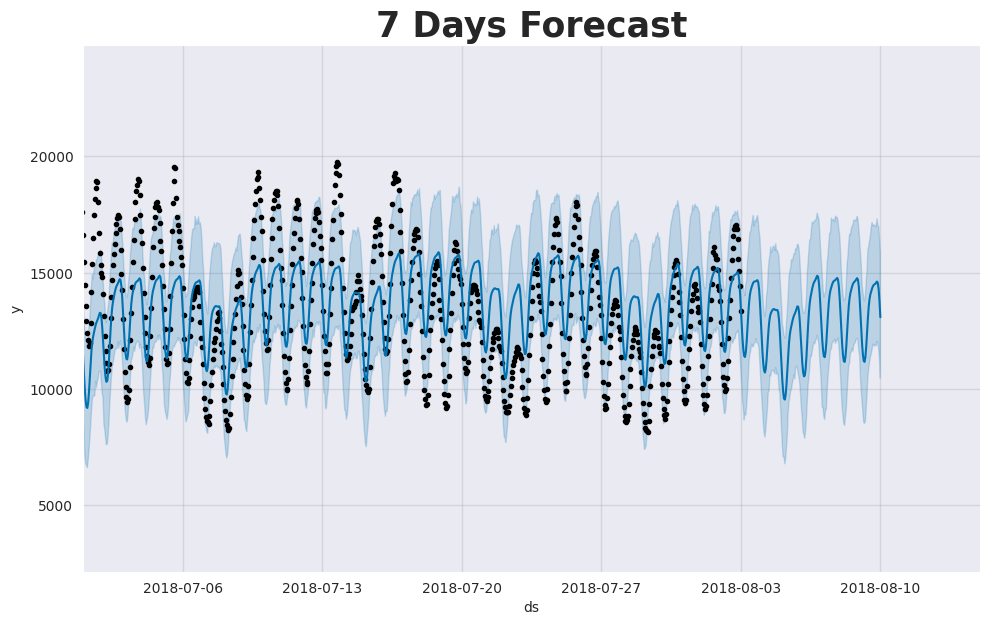

In [103]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-15']))
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

In [10]:
dataset = tf.expand_dims(df_train['COMED_MW'].head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[9970.]
 [9428.]
 [9059.]
 [8817.]]
y =  [8743.]

x =  [[9428.]
 [9059.]
 [8817.]
 [8743.]]
y =  [8735.]

x =  [[9059.]
 [8817.]
 [8743.]
 [8735.]]
y =  [8993.]

x =  [[8817.]
 [8743.]
 [8735.]
 [8993.]]
y =  [9363.]

x =  [[8743.]
 [8735.]
 [8993.]
 [9363.]]
y =  [9545.]

x =  [[8735.]
 [8993.]
 [9363.]
 [9545.]]
y =  [9676.]



In [11]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [12]:
train = windowing(df_train['COMED_MW'], 24, 72, 32)
test = windowing(df_test['COMED_MW'], 24, 72, 32)

In [13]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 24, 16)              │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - loss: 2866.2271 - val_loss: 826.9711
Epoch 2/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - loss: 824.3977 - val_loss: 988.5584
Epoch 3/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 873.4438 - val_loss: 860.8883
Epoch 4/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - loss: 837.1558 - val_loss: 748.7779
Epoch 5/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 660.8480 - val_loss: 543.9111
Epoch 6/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 405.0557 - val_loss: 290.5940
Epoch 7/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 267.0162 - val_loss: 236.7846
Epoch 8/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 261.5938 - val_loss: 239.6324
Epoch 9/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 254.1482 - val_loss: 269.2338
Epoch 10/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 246.7083 - val_loss: 240.6962
Epoch 11/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step -

<Axes: >

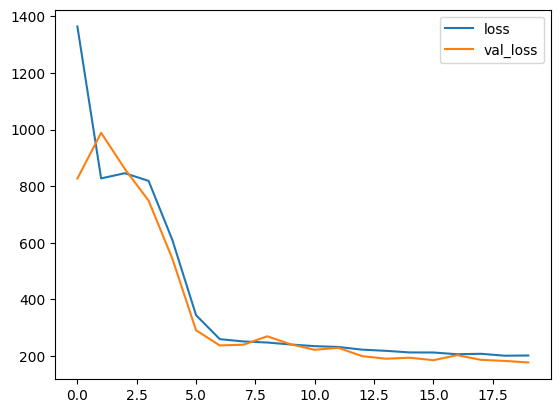

In [15]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

### Causal Modeling

In [ ]:
!pip install dowhy

In [16]:
df_comed_energy.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


In [17]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_comed_energy = create_features(df_comed)

In [18]:
df_comed_energy.head()

,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2011-12-31 01:00:00,9970.0,1,5,4,12,2011,365,31,52
2011-12-31 02:00:00,9428.0,2,5,4,12,2011,365,31,52
2011-12-31 03:00:00,9059.0,3,5,4,12,2011,365,31,52
2011-12-31 04:00:00,8817.0,4,5,4,12,2011,365,31,52
2011-12-31 05:00:00,8743.0,5,5,4,12,2011,365,31,52


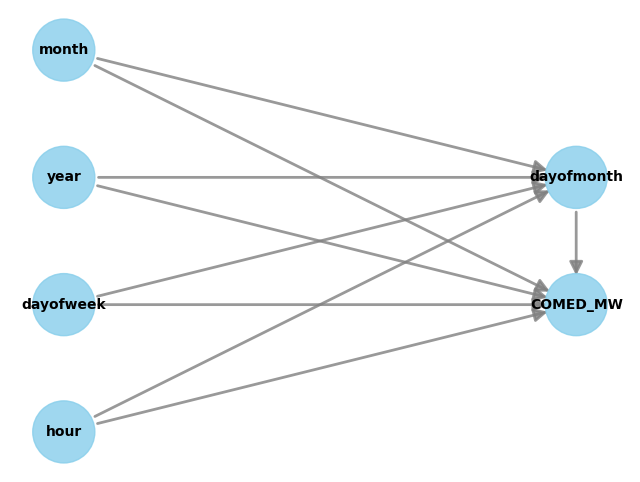

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                             
─────────────(E[COMED_MW|hour,dayofweek,year,month])
d[dayofmonth]                                       
Estimand assumption 1, Unconfoundedness: If U→{dayofmonth} and U→COMED_MW then P(COMED_MW|dayofmonth,hour,dayofweek,year,month,U) = P(COMED_MW|dayofmonth,hour,dayofweek,year,month)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Causal Effect:
-1.5173401542524516


In [21]:
# Define treatment, outcome, and covariates
treatment = "dayofmonth"   # Treatment variable: time of month
outcome = "COMED_MW"       # Outcome variable: energy consumption
covariates = ["hour", "dayofweek", "month", "year"]  # Confounders

# Step 1: Build the causal model
model = CausalModel(
    data=df_comed_energy,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)

# Step 2: Visualize the causal graph
model.view_model()
# The causal graph is generated and saved as a file (e.g., causal_model.png)

# Step 3: Identify the causal effect
identified_estimand = model.identify_effect()
print("Identified Estimand:")
print(identified_estimand)

# Step 4: Estimate the causal effect
causal_effect = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"  # Linear regression for effect estimation
)
print("\nCausal Effect:")
print(causal_effect.value)


#### 💡 Observations and Inference:
> This outcome provides insights into the causal relationship between  (start or end of the month) and energy consumption (). Here's a breakdown of the results:

This outcome provides insights into the causal relationship between `dayofmonth` (start or end of the month) and energy consumption (`COMED_MW`). Here's a breakdown of the results:

---

### **Interpretation of the Outcome**

#### **Identified Estimand**:
1. **Estimand Type**:
   - The type is `NONPARAMETRIC_ATE`, which refers to the *Average Treatment Effect (ATE)*. This means the analysis is trying to estimate the average causal effect of changing the `dayofmonth` on energy consumption across the dataset.

2. **Backdoor Estimand (Estimand 1)**:
   - **Expression**:
     
  $\frac{d}{d[\text{dayofmonth}]}(E[\text{COMED\_MW} \mid \text{hour, dayofweek, year, month}])$

     - This indicates that the causal effect of `dayofmonth` on `COMED_MW` is being adjusted for the covariates `hour`, `dayofweek`, `year`, and `month` to satisfy the backdoor criterion. These covariates act as confounders, ensuring that the effect is not biased by their influence.
   - **Assumption**:  
     Unconfoundedness is assumed. This means that, given the observed covariates (`hour, dayofweek, year, month`), there are no unobserved variables (`U`) affecting both `dayofmonth` and `COMED_MW`. This is a strong assumption necessary to identify the causal effect.

3. **Instrumental Variables (IV) and Frontdoor Estimand**:
   - No instrumental variable (IV) or frontdoor estimand was found. This indicates that neither method could be used to estimate the causal effect due to the absence of suitable variables in the dataset. As a result, the backdoor criterion was selected for the analysis.

---

#### **Causal Effect**:
- **Value**: `-1.5173401542524516`
   - This indicates that a 1-unit increase in `dayofmonth` (e.g., moving one day later in the month) causes an average decrease of approximately **1.52 MW** in energy consumption, holding all other covariates constant (`hour`, `dayofweek`, `year`, `month`).

---

### **Key Takeaways**:
1. **Negative Causal Effect**:
   - The result suggests that as the `dayofmonth` increases (moving towards the end of the month), energy consumption tends to **decrease**. This might reflect behavioral or operational patterns, such as reduced demand at the end of the month due to industrial or residential activity cycles.

2. **Backdoor Adjustment**:
   - The analysis successfully accounted for potential confounders (`hour`, `dayofweek`, `year`, `month`) to isolate the causal relationship between `dayofmonth` and `COMED_MW`.

3. **Model Limitations**:
   - Since no instrumental variables or frontdoor paths were available, the backdoor adjustment was the only feasible method for estimating the causal effect. This means the results depend heavily on the validity of the unconfoundedness assumption.

---

### **Possible Next Steps**:
1. **Validate Assumptions**: Ensure that all key confounders have been included in the model. Unobserved variables could still bias the estimate if they influence both `dayofmonth` and `COMED_MW`.
2. **Domain Insights**: Investigate whether the observed decrease in energy consumption at the end of the month aligns with practical or industry-specific knowledge (e.g., production schedules, billing cycles, etc.).
3. **Temporal Analysis**: Expand the dataset to include more time periods and test if this pattern holds consistently across different months, seasons, or years.
